## Import Libraries

In [28]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import math
import statsmodels.formula.api as smf

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score, davies_bouldin_score
from IPython.display import HTML

pd.set_option('display.max_columns', None)      # show all columns in a dataframe

# horizontal DataFrame display
def horizontal(dfs):
    html = '<div style="display:flex">'
    for df in dfs:
        html += '<div style="margin-right: 32px">'
        html += df.to_html()
        html += '</div>'
    html += '</div>'
    display(HTML(html))

plt.rcParams['axes.grid'] = False

# color_palette = ["#165788", "#F7403A", "#F1E3BB", "#D1D4D3", "#E1B0B7", "#BBE7E6"]    # Omnium theme colors

# Pipeline Functions

### Importing & Preprocessing

In [29]:
# --- Importing Excel Files ---
def import_excel(filename, sheetname, cwd=os.getcwd(), header=0):
    INPUT_FILEPATH = os.path.join(cwd, filename)
    return pd.read_excel(INPUT_FILEPATH, sheet_name=sheetname, header=header)

# --- Pandas Datetime ---
def date(year, month=1, day=1, year_beginning=False, year_ending=False):
    if year_beginning:
        return pd.Timestamp(year=year, month=1, day=1)
    elif year_ending:
        return pd.Timestamp(year=year, month=12, day=31, hour=23)
    return pd.Timestamp(year=year, month=month, day=day)

# --- Standardize column names ---
def standardize_columns(df, 
                        date="OM Date", 
                        geo="Geography", 
                        base_dollars = "Auto.Base.Dollars", 
                        base_units = "Auto.Base.Units",
                        stores_selling="Number of Stores Selling", 
                        acv="ACV Weighted Distribution", 
                        product="Product", 
                        promo_code="Auto.Promo.Code", 
                        lower_flag="Lower", 
                        channel_of_trade="COT", 
                        account="OM Account", 
                        price_bucket="Price Bucket Half Dollar", 
                        product_group = "OM PG", 
                        period = "Period"):
    df = df.rename(columns={
        date: "Date",
        geo: "Geography",
        base_dollars: "Base Dollars",
        base_units: "Base Units",
        stores_selling: "# of Stores Selling",
        acv: "ACV",
        product: "SKU",
        promo_code:"Promo Code",
        lower_flag:"Lower",
        channel_of_trade:"COT",
        account:"OM Account",
        price_bucket:"Price Bucket",
        product_group:"OM PG",
        period:"Period (13)"
    }).copy()
    return df

# --- Calculate weekly velocity ---
def calculate_weekly_velocity(df, week_lkup, geography_filter, start_date=None, end_date=None, acv_threshold=5, use_units=False):

    """Filter data by geography/date, apply ACV threshold, map weeks, and compute weekly velocity (base sales per store) in dollars or units."""
    
    df = df[df["Geography"].str.lower() == geography_filter.lower()]
    if start_date is not None:
        df = df[df["Date"] >= start_date]
    if end_date is not None:
        df = df[df["Date"] < end_date]
    df = df[df.groupby("SKU")["ACV"].transform('max') > acv_threshold]
    df = df.merge(week_lkup, left_on="Date", right_on="Date", how="left")

    metric = "Dollars"
    if use_units:
        metric = "Units"
    grouped = df.groupby("Week Number")[["Base "+metric, "# of Stores Selling"]].sum()
    grouped["Velocity"] = grouped["Base "+metric] / grouped["# of Stores Selling"]
    grouped = grouped.reset_index()[["Week Number", "Velocity"]].sort_values("Week Number")
    return grouped

### Custom Distance Functions

In [30]:
def dist_linear(obs_1, obs_2, alpha, min_velocity, max_velocity):

    """Linear combination of normalized week difference and velocity difference."""

    week_diff = min(abs(obs_1[0] - obs_2[0]), 52 - abs(obs_1[0] - obs_2[0]))
    week_norm = week_diff / 26
    vel_1 = obs_1[1]
    vel_2 = obs_2[1]
    vel_norm = abs(vel_1 - vel_2) / (max_velocity - min_velocity + 1e-8)
    return alpha * week_norm + (1 - alpha) * vel_norm

def dist_squared(obs_1, obs_2, alpha, min_velocity, max_velocity):
    
    """Linear combination of normalized week difference and squared velocity difference."""

    week_diff = min(abs(obs_1[0] - obs_2[0]), 52 - abs(obs_1[0] - obs_2[0]))
    week_norm = week_diff / 26
    vel_1 = obs_1[1]
    vel_2 = obs_2[1]
    vel_norm = abs(vel_1 - vel_2) / (max_velocity - min_velocity)
    vel_sq = vel_norm ** 2
    return alpha * week_norm + (1-alpha) * vel_sq

def dist_exp_decay(obs_1, obs_2, alpha, min_velocity, max_velocity):
    
    """Linear combination of exponential week decay and velocity difference."""

    week_diff = min(abs(obs_1[0] - obs_2[0]), 52 - abs(obs_1[0] - obs_2[0]))
    tau = 6
    week_decay = 1 - math.exp(-week_diff / tau)
    vel_1 = obs_1[1]
    vel_2 = obs_2[1]
    vel_norm = abs(vel_1 - vel_2) / (max_velocity - min_velocity + 1e-8)
    return alpha * week_decay + (1 - alpha) * vel_norm

def dist_cosine(obs_1, obs_2, alpha, min_velocity, max_velocity):
    
    """Linear combination of cosine-based week similarity (within 4 weeks) or linear week difference, and velocity difference."""

    week_diff = min(abs(obs_1[0] - obs_2[0]), 52 - abs(obs_1[0] - obs_2[0]))
    width = 4
    if week_diff <= width:
        week_bump = 0.5 * (1 - math.cos(math.pi * week_diff / width))
    else:
        week_bump = week_diff / 26
    vel_1 = obs_1[1]
    vel_2 = obs_2[1]
    vel_norm = abs(vel_1 - vel_2) / (max_velocity - min_velocity + 1e-8)
    return alpha * week_bump + (1 - alpha) * vel_norm

def get_custom_distance_matrix(X, alpha, min_v, max_v, distance_fn):

    """Compute square and condensed distance matrices using a custom distance function with velocity normalization."""
    
    def wrapped(u, v):
        return distance_fn(u, v, alpha, min_v, max_v)
    D_condensed = pdist(X, metric=wrapped)
    D_square = squareform(D_condensed)
    return D_square, D_condensed

### Clustering & Plotting

In [31]:
# --- Compute linkage, clustering, and scores ---
def compute_linkage_scores(weekly_velocity, linkage_methods, k_max, k_to_show=0, custom_distance=False, alpha=0.1, distance_fn=dist_exp_decay):

    """Performs hierarchical clustering on weekly velocity data for each linkage method, evaluating K=2..k_max with silhouette, Calinski–Harabasz, and Davies–Bouldin scores.

    Args:
        weekly_velocity (pd.DataFrame): Must contain 'Week Number' (1-52) and 'Velocity'.
        linkage_methods (list[str]): Linkage methods to evaluate (e.g., ["single","average"]).
        k_max (int): Maximum number of clusters to test.
        k_to_show (int, optional): If 0, choose K by max silhouette; otherwise use this fixed K.
        custom_distance (bool, optional): If True, cluster on [Week Number, Velocity] using 
            a custom time-velocity distance function; else use velocity-only distances.
        alpha (float, optional): Time vs. velocity weight for the custom distance function.
        distance_fn (callable, optional): Function with signature 
            (obs1, obs2, alpha, min_v, max_v) -> float, used if custom_distance=True.

    Returns:
        dict: Keys are linkage method names; each value contains:
            {
            "Z": linkage matrix,
            "sil": list of silhouette scores (K=2..),
            "ch": list of Calinski-Harabasz scores (K=2..),
            "db": list of Davies-Bouldin scores (K=2..),
            "best_k": selected cluster count,
            "best_labels": cluster labels for best_k,
            "used_custom_distance": bool,
            "dist_square": NxN distance matrix (only if custom_distance=True)
            }
    """

    score_dict = {}
    velocities = weekly_velocity["Velocity"].values.reshape(-1, 1)
    X = weekly_velocity[["Week Number", "Velocity"]].to_numpy()

    v_min = float(weekly_velocity["Velocity"].min())
    v_max = float(weekly_velocity["Velocity"].max())

    if custom_distance:
        D_square, D_condensed = get_custom_distance_matrix(
            X=X,
            alpha=alpha,
            min_v=v_min,
            max_v=v_max,
            distance_fn=distance_fn
        )

    for method in linkage_methods:
        if custom_distance:
            Z = linkage(D_condensed, method=method)
        else:
            Z = linkage(velocities, method=method)

        sil_scores, ch_scores, db_scores = [], [], []
        k_range = range(2, min(k_max + 1, len(velocities)))

        for k in k_range:
            labels = fcluster(Z, t=k, criterion='maxclust')
            if len(np.unique(labels))==1:
                sil_scores.append(np.nan)
                ch_scores.append(np.nan)
                db_scores.append(np.nan)
            else:
                if custom_distance:
                    sil = silhouette_score(D_square, labels, metric="precomputed")
                else:
                    sil = silhouette_score(velocities, labels)
                ch = calinski_harabasz_score(velocities, labels)
                db = davies_bouldin_score(velocities, labels)

                sil_scores.append(sil)
                ch_scores.append(ch)
                db_scores.append(db)

        if k_to_show == 0:
            best_k = int(np.nanargmax(sil_scores)) + 2
        else:
            best_k = k_to_show
        best_labels = fcluster(Z, t=best_k, criterion='maxclust')

        score_dict[method] = {
            "Z": Z,
            "sil": sil_scores,
            "ch": ch_scores,
            "db": db_scores,
            "best_k": best_k,
            "best_labels": best_labels,
            "used_custom_distance": bool(custom_distance)
        }
        if custom_distance:
            score_dict[method]["dist_square"] = D_square
    return score_dict
    
# --- Plot pipeline ---
def plot_clustering_pipeline(weekly_velocity, score_dict):

    """Generates visual outputs for clustering results:

    1. **Average Weekly Velocity** - Line plot of weekly velocity over weeks with mean line.
    2. **Clustered Velocity Scatter** - Week vs. velocity points colored by cluster assignment.
    3. **Dendrogram** - Hierarchical tree showing cluster merges and distances.
    4. **Silhouette Plot** - Horizontal bars of silhouette values per cluster with mean line.
    5. **Metric Line Plots** - For each K, plots Silhouette, Calinski-Harabasz, and Davies-Bouldin scores.
    """

    velocities = weekly_velocity["Velocity"].values.reshape(-1, 1)
    linkage_methods = list(score_dict.keys())
    num_methods = len(linkage_methods)

    # --- Average Weekly Velocity ---
    fig_avg, ax_avg = plt.subplots(figsize=(8, 3))
    sns.lineplot(data=weekly_velocity, x="Week Number", y="Velocity", ax=ax_avg)
    ax_avg.plot(
        weekly_velocity["Week Number"],
        [weekly_velocity["Velocity"].mean()] * len(weekly_velocity),
        linestyle="--", color="gray"
    )
    ax_avg.set_ylim(bottom=0)
    ax_avg.set_title("Average Weekly Velocity (Aggregated Over Years)")
    ax_avg.set_xlabel("Week Number")
    ax_avg.set_ylabel("Base Dollar Velocity")
    fig_avg.tight_layout()
    plt.show()

    # --- Grid for all clustering visuals ---
    fig, axes = plt.subplots(
        nrows=6, ncols=num_methods, figsize=(8 * num_methods, 28),
        gridspec_kw={"hspace": 0.4, "wspace": 0.3}
    )

    score_keys = ["sil", "ch", "db"]
    score_titles = ["Silhouette Score", "Calinski-Harabasz Index", "Davies-Bouldin Index"]

    for i, method in enumerate(linkage_methods):
        Z = score_dict[method]["Z"]
        best_k = score_dict[method]["best_k"]
        best_labels = score_dict[method]["best_labels"]
        used_custom = score_dict[method].get("used_custom_distance", False)

        # --- Clustered velocity plot ---
        scatter_ax = axes[0, i]
        sns.scatterplot(
            x=weekly_velocity["Week Number"], y=weekly_velocity["Velocity"],
            hue=best_labels, palette="tab10", s=80, ax=scatter_ax, legend=False
        )
        scatter_ax.plot(
            weekly_velocity["Week Number"], weekly_velocity["Velocity"],
            linestyle='dashed', color='gray'
        )
        scatter_ax.set_title(f"Weekly Velocity (k={best_k}, {method.title()})")
        scatter_ax.set_xlabel("Week Number")
        scatter_ax.set_ylabel("Base Dollar Velocity")

        # --- Dendrogram ---
        dend_ax = axes[1, i]
        dendrogram(Z, labels=weekly_velocity["Week Number"].values, leaf_rotation=90, leaf_font_size=8, ax=dend_ax)
        dend_ax.set_title(f"Dendrogram ({method.title()})")
        dend_ax.set_xlabel("Week Number")
        dend_ax.set_ylabel("Distance")

        # --- Best silhouette bar plot ---
        sil_ax = axes[2, i]
        if used_custom:
            D_square = score_dict[method]["dist_square"]
            sil_vals = silhouette_samples(D_square, best_labels, metric="precomputed")
        else:
            sil_vals = silhouette_samples(velocities, best_labels)

        y_lower = 10
        for j in range(1, best_k + 1):
            cluster_vals = sil_vals[best_labels == j]
            cluster_vals.sort()
            size = cluster_vals.shape[0]
            y_upper = y_lower + size
            sil_ax.barh(np.arange(y_lower, y_upper), cluster_vals, height=1.0, alpha=0.7)
            sil_ax.text(-0.05, y_lower + 0.5 * size, str(j))
            y_lower = y_upper + 10
        sil_ax.axvline(np.mean(sil_vals), color="red", linestyle="--")
        sil_ax.set_title(f"Silhouette Plot (k={best_k}, {method.title()})")
        sil_ax.set_xlim([-0.2, 1])
        sil_ax.set_xticks(np.arange(-0.2, 1.05, 0.2))
        sil_ax.set_yticks([])

        # --- Metric line plots ---
        for r, metric in enumerate(score_keys):
            vals = score_dict[method][metric]
            xvals = range(2, 2 + len(vals))
            ax = axes[3 + r, i]
            ax.plot(xvals, vals, marker='o')
            ax.set_title(f"{score_titles[r]} ({method.title()})")
            ax.set_xlabel("Number of Clusters")
            ax.set_ylabel(score_titles[r])
            if metric == "sil":
                ax.set_ylim([-1, 1])
            else:
                ax.set_ylim(bottom=0)
            ax.set_xticks(list(xvals))
    plt.show()

def optimize_alpha(weekly_velocity, linkage_methods, print_each_alpha, k_max, n_alphas):

    """Optimize and visualize alpha (time-velocity weight) for custom distance clustering.

    For each linkage method:
        1. Determine best_k from standard velocity-only clustering.
        2. Sweep alpha values from 0 to ~1 in n_alphas steps, 
        running custom distance clustering each time.
        3. Record silhouette score at best_k and track the alpha with the highest score.
    Returns:
        best_alphas: {method: (best_alpha, best_score)}
        all_results: {method: [(alpha, silhouette_score), ...]}
        best_ks: {method: best_k}"""
    
    alphas = np.linspace(0, .999, n_alphas)
    best_alphas = {}
    all_results = {}
    best_ks = {}

    for method in linkage_methods:
        method_results = []
        best_score = -np.inf
        best_alpha = None

        not_custom_dist_scores = compute_linkage_scores(
            weekly_velocity=weekly_velocity,
            linkage_methods=[method],
            k_max=k_max
        )
        best_k = not_custom_dist_scores[method]["best_k"]

        if print_each_alpha:
            print(f"\nOptimizing for linkage: {method}")
            print(f"K value being compared: {best_k}")

        for alpha in alphas:
            scores = compute_linkage_scores(
                weekly_velocity=weekly_velocity,
                linkage_methods=[method],
                k_max=k_max,
                custom_distance=True,
                alpha=alpha
            )

            sil = scores[method]["sil"][best_k - 2]
            method_results.append((alpha, sil))
            if print_each_alpha:
                print(f"Trying alpha = {alpha:.2f} \t\t silhouette score = {sil:.2f}")

            if sil > best_score:
                best_score = sil
                best_alpha = alpha

        best_alphas[method] = (best_alpha, best_score)
        all_results[method] = method_results
        best_ks[method] = best_k

    return best_alphas, all_results, best_ks

def print_optimized_alpha(weekly_velocity, linkage_methods, print_each_alpha=False, k_max=13, n_alphas=21):

    """Calls optimize_alpha, prints best alpha/score for each method, and plots silhouette score vs. alpha for all tested linkage methods."""
    
    best_alphas, all_alpha_results, best_ks = optimize_alpha(weekly_velocity, linkage_methods, print_each_alpha, k_max, n_alphas)
    fig, axes = plt.subplots(1, len(best_alphas), figsize=(6 * len(best_alphas), 6))

    if len(best_alphas) == 1:
        axes = [axes]

    for counter, (method, (alpha, score)) in enumerate(best_alphas.items()):
        print(f"{method}: K being compared = {best_ks[method]}, best alpha = {alpha:.2f}, silhouette = {score:.4f}")
        alphas, sil_scores = zip(*all_alpha_results[method])
        axes[counter].plot(alphas, sil_scores)
        axes[counter].set_title(method)
        axes[counter].set_xlabel("Alpha")
        axes[counter].set_ylabel("Silhouette Score")
        axes[counter].grid(True)

    plt.tight_layout()
    plt.show()

### Regressions

In [32]:
# --- Mapping in clustered periods ---
def map_weeks_to_clusters(data, week_lkup, weekly_velocity, score_dict, method="single", k_override=0):

    """Assigns each row in data to a seasonal cluster by mapping weeks (from week_lkup) to cluster labels from score_dict for the chosen linkage method and K."""

    if method not in score_dict:
        raise ValueError(f"Method '{method}' not found in score_dict. Available: {list(score_dict.keys())}")

    Z = score_dict[method]["Z"]
    k = score_dict[method]["best_k"] if k_override==0 else k_override
    labels = fcluster(Z, t=k, criterion="maxclust")
    weekly_velocity = weekly_velocity.copy()
    weekly_velocity["Period Cluster"] = labels
    data_w_weeknum = data.merge(week_lkup, left_on="Date", right_on="Date", how="left")
    combined = data_w_weeknum.merge(weekly_velocity[["Week Number", "Period Cluster"]], left_on="Week Number", right_on="Week Number", how="left")
    return combined

# --- Regressions ---
def run_price_factor_regression(
    data,
    sku_filter=[],
    pg_filter=[],
    period_col_name="",
    lower_filter=1,
    cot_filter="Food",
    acv_min=10,
    price_min=6.49,
    price_max=8.99,
    date_min=None,
    date_max=None
):
    """Estimate price-bin fixed effects and a constant elasticity, and return a formatted demand table.

    Filters: non-promo, given Lower/COT/ACV range, nonzero Base Units, and Price Bucket in [min,max],
    with optional SKU/PG/date filters. Models:
      • Fixed-effects OLS: log(Base Units) ~ PriceFactor + log(ACV) + Account + [Period] + [SKU]
      • Elasticity OLS:   log(Base Units) ~ log(Price Bucket) + log(ACV) + Account + [Period] + [SKU]
    Returns: (demand_df with Price | Percent of Base Units | Demand Index, fixed-effects model).
    """
    
    # Base filters
    f = (
        (data["Promo Code"] == 0) &
        (data["Lower"] == lower_filter) &
        (data["COT"] == cot_filter) &
        (data["ACV"] >= acv_min) &
        (data["Base Units"] != 0) &
        (data["Price Bucket"] >= price_min) &
        (data["Price Bucket"] <= price_max)
    )
    df = data[f].copy()
    if sku_filter:
        df = df[df["SKU"].isin(sku_filter)]
    if pg_filter:
        df = df[df["OM PG"].isin(pg_filter)]
    if date_min is not None:
        df = df[df["Date"] >= date_min]
    if date_max is not None:
        df = df[df["Date"] <= date_max]

    # Factors
    df["PriceFactor"] = df["Price Bucket"].astype("category")
    df["AccountFactor"] = df["OM Account"].astype("category")
    use_period = bool(period_col_name)
    use_sku = bool(pg_filter)

    if use_period:
        df["PeriodFactor"] = df[period_col_name].astype("category")
    if use_sku:
        df["SKUFactor"] = df["Product"].astype("category")

    # Build formulas once
    y = "np.log(Q('Base Units'))"
    rhs_common = ["PriceFactor", "np.log(Q('ACV'))", "AccountFactor"]
    rhs_elast = ["np.log(Q('Price Bucket'))", "np.log(Q('ACV'))", "AccountFactor"]
    if use_period:
        rhs_common.append("PeriodFactor")
        rhs_elast.append("PeriodFactor")
    if use_sku:
        rhs_common.append("SKUFactor")
        rhs_elast.append("SKUFactor")

    fe_formula = f"{y} ~ {' + '.join(rhs_common)}"
    el_formula = f"{y} ~ {' + '.join(rhs_elast)}"

    # Fit models
    model = smf.ols(formula=fe_formula, data=df).fit()
    elasticity_model = smf.ols(formula=el_formula, data=df).fit()

    # Price-factor coefficients → demand index
    cats = df["PriceFactor"].cat.categories
    price_coefs = model.params[model.params.index.str.startswith("PriceFactor")]
    named_levels = price_coefs.index.str.replace("PriceFactor[T.", "", regex=False).str.replace("]", "", regex=False)
    base_level = next(c for c in cats.astype(str) if c not in list(named_levels))

    all_prices = pd.Series(
        data=np.concatenate(([0.0], price_coefs.values)),
        index=[base_level] + list(named_levels)
    )
    demand_index = np.exp(all_prices)
    demand_index_norm = demand_index / demand_index.max()

    demand_df = pd.DataFrame({
        "Price": demand_index_norm.index.astype(str),
        "Demand Index": demand_index_norm.values
    })

    # Percent of base units per price bin
    units_by_bin = df.groupby("PriceFactor", observed=True)["Base Units"].sum().reindex(cats, fill_value=0)
    units_df = units_by_bin.rename_axis("PriceFactor").reset_index()
    units_df["Price"] = units_df["PriceFactor"].astype(str)
    total_units = units_df["Base Units"].sum()
    units_df["Percent of Base Units"] = 0.0 if total_units == 0 else 100.0 * units_df["Base Units"] / total_units

    demand_df = demand_df.merge(units_df[["Price", "Percent of Base Units"]], on="Price", how="left")

    # Print constant elasticity
    coef_name = "np.log(Q('Price Bucket'))"
    if coef_name in elasticity_model.params.index:
        elasticity = elasticity_model.params[coef_name]
        print(f"Constant price elasticity (log-log): {elasticity:.3f}")
    else:
        print("Constant price elasticity could not be estimated in the log-log model.")

    # Format & order columns
    demand_df["Percent of Base Units"] = demand_df["Percent of Base Units"].astype(float).map(lambda x: f"{x:.1f}%")
    demand_df["Demand Index"] = demand_df["Demand Index"].map(lambda x: f"{x:.2f}")
    demand_df = demand_df[["Price", "Percent of Base Units", "Demand Index"]].reset_index(drop=True)

    return demand_df, model


## Global Constants

In [33]:
week_mapping_name = "Mapped_Week_Numbers.xlsx"
linkage_methods = ["single", "complete", "average", "weighted", "centroid", "median", "ward"]
account = "TOTAL US - FOOD"
k_max = 13
alpha = .1     # coefficient for time-based distance; coefficient for velocity is 1-alpha

# Chomps (Low Seasonality)

### Importing Files

In [8]:
filename = "250310 - Seasonality.xlsx"
sheetname = "data"
week_mapping_sheet_name = "chomps_week_lkup"
chomps_data = import_excel(filename, sheetname)
chomps_week_lkup = import_excel(week_mapping_name, week_mapping_sheet_name)
chomps_data.head(3)

Geography Time Period Time Period End Date Product Universe  \
0  TOTAL US - FOOD        WEEK           2022-10-23              TPL   
1  TOTAL US - FOOD        WEEK           2022-03-13              TPL   
2  TOTAL US - FOOD        WEEK           2022-03-06              TPL   

  Product Level                          Category Subcategory          Brand  \
0           UPC  SHELF STABLE JERKY & MEAT SNACKS    SS JERKY  BUFFALO RANGE   
1           UPC  SHELF STABLE JERKY & MEAT SNACKS    SS JERKY  BUFFALO RANGE   
2           UPC  SHELF STABLE JERKY & MEAT SNACKS    SS JERKY  BUFFALO RANGE   

              UPC                  Description           PRODUCT TYPE  SIZE  \
0  00-10279-81011  Blrn1 Reg Bf Jrky Ss 3.25oz  SS MEAT SNACK - JERKY  3.25   
1  00-10279-81011  Blrn1 Reg Bf Jrky Ss 3.25oz  SS MEAT SNACK - JERKY  3.25   
2  00-10279-81011  Blrn1 Reg Bf Jrky Ss 3.25oz  SS MEAT SNACK - JERKY  3.25   

  UNIT OF MEASURE  Dollars  Units  Max % ACV  TDP  Number of Weeks Selling  \
0           OUNCE  2287.38  336.3        1.5  1.5                        1   
1           OUNCE  2540.20  369.5        1.6  1.6                        1   
2           OUNCE  2990.40  439.9        1.9  1.9                        1   

   Base Dollars  Base Units  # of Stores  # of Stores Selling  
0       2043.45       290.3        32358                  291  
1       2463.49       349.4        32297                  313  
2       2801.44       398.4        32299                  352

### Running Pipeline

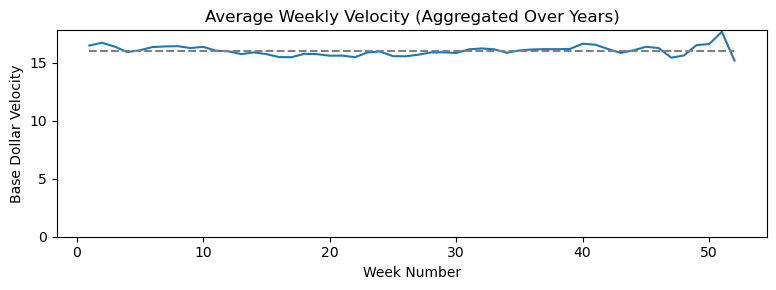

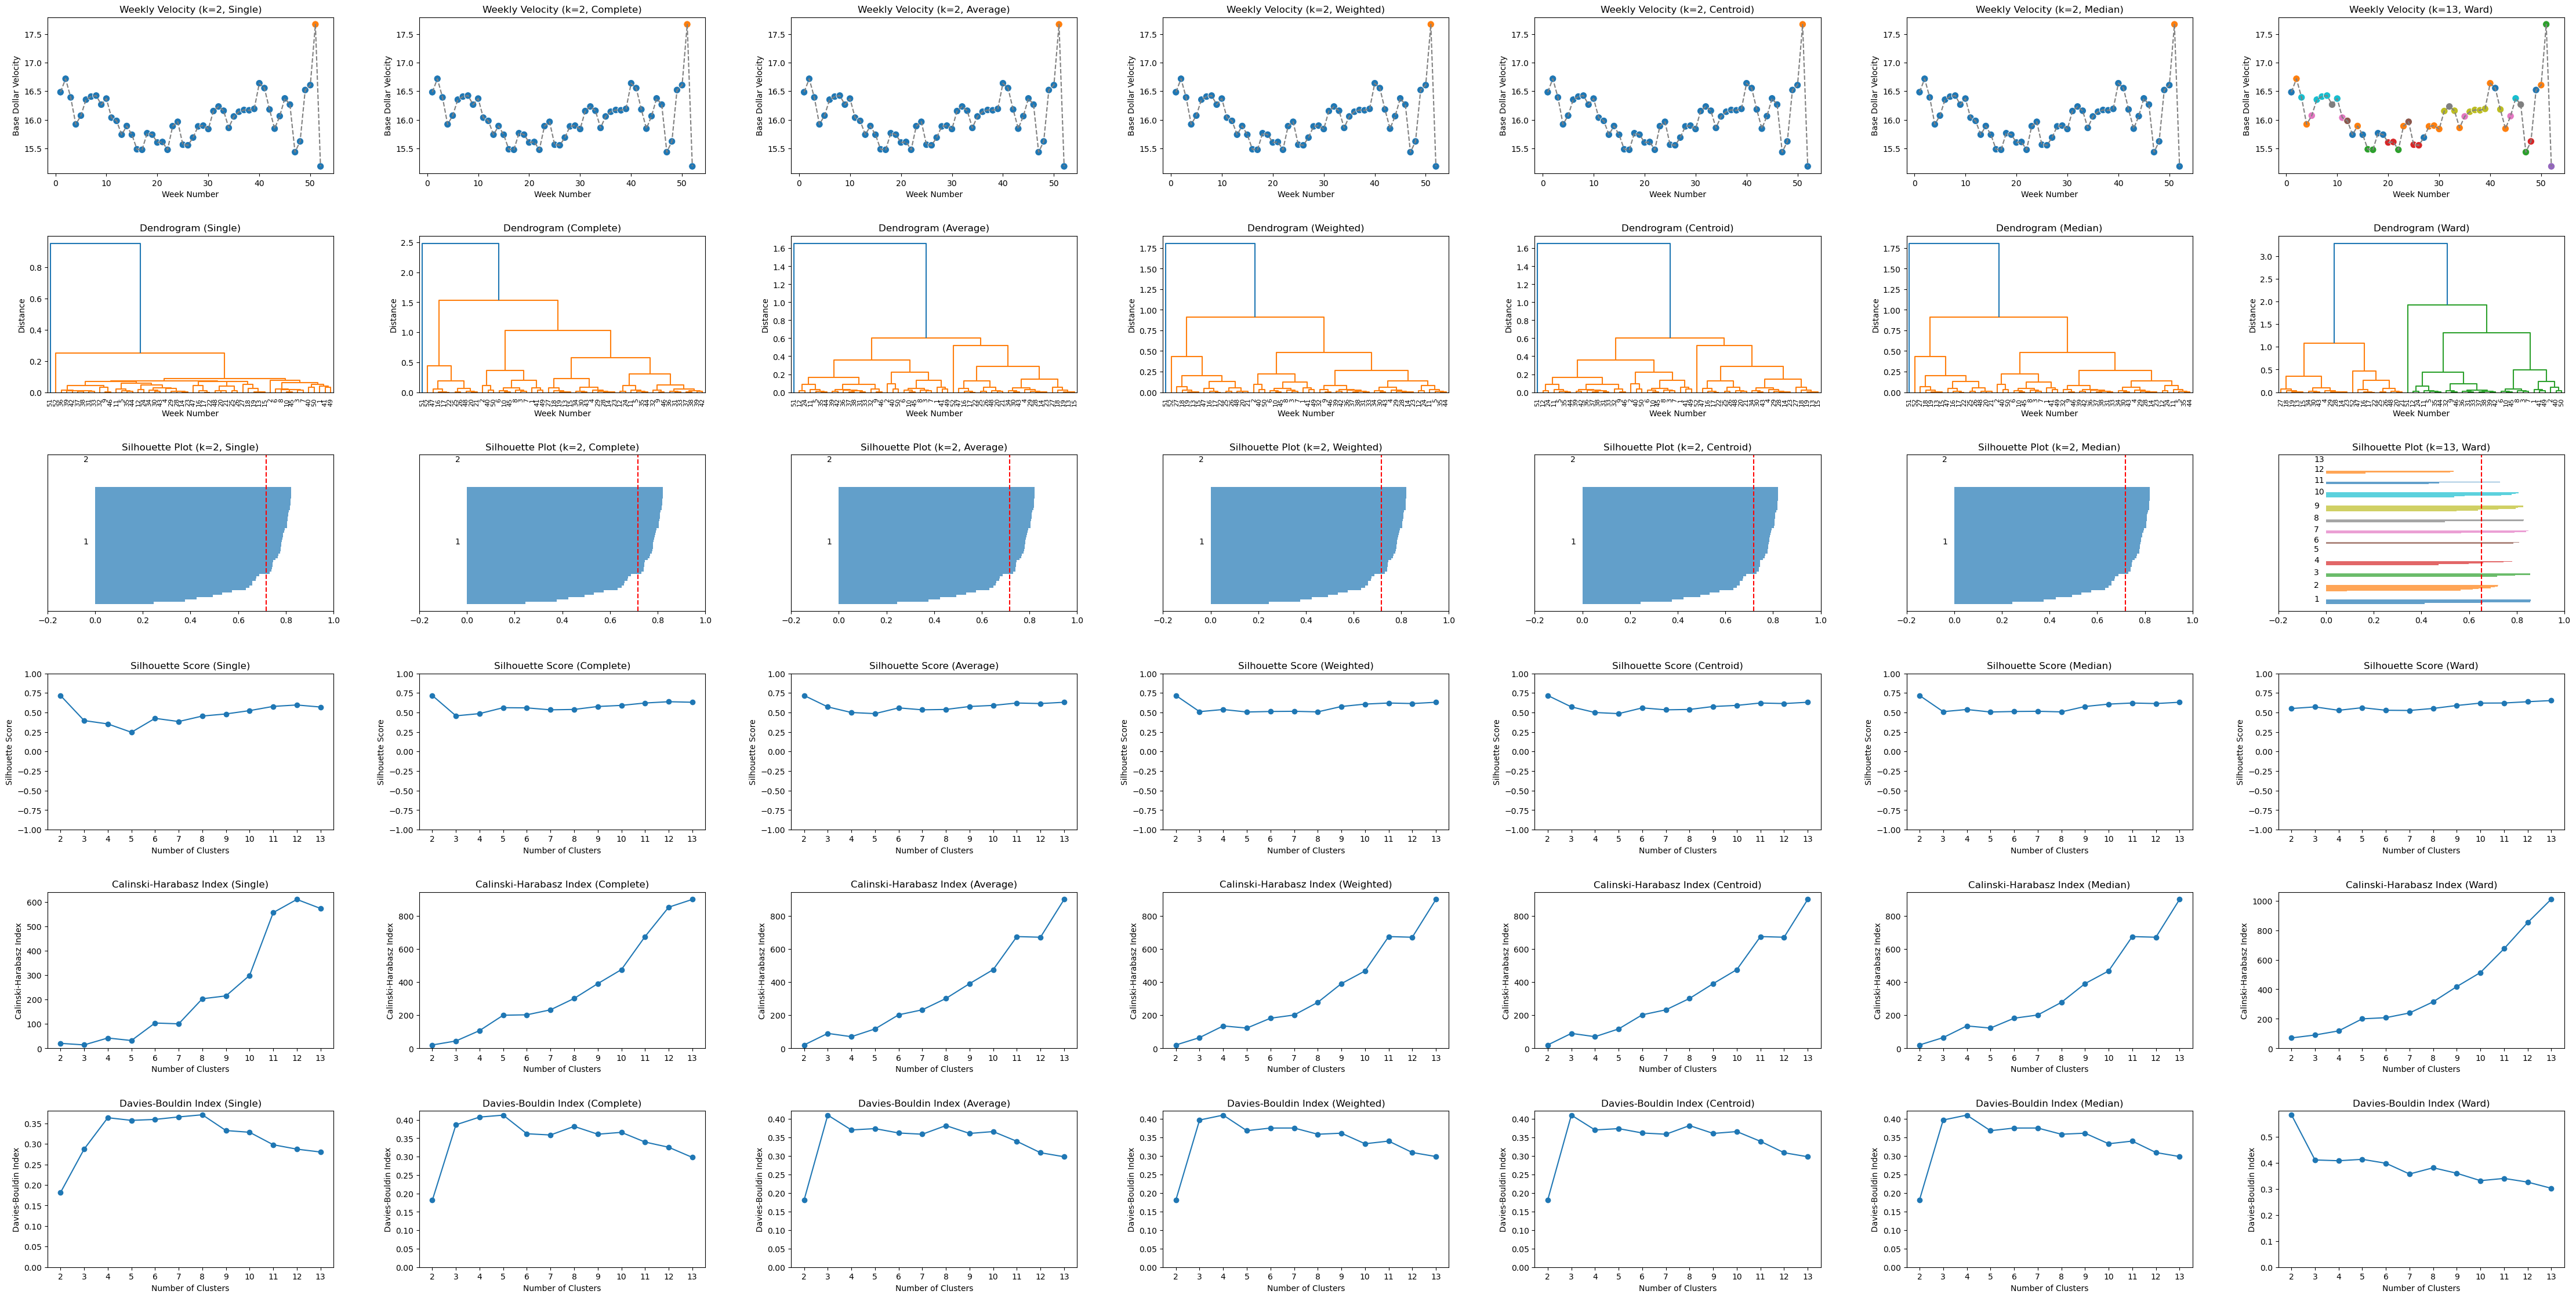

In [9]:
chomps_data_relabeled = standardize_columns(chomps_data, date="Time Period End Date", geo="Geography", base_dollars="Base Dollars", stores_selling="# of Stores Selling", acv="Max % ACV", product="Description")
weekly_velocity = calculate_weekly_velocity(chomps_data_relabeled, chomps_week_lkup, account, date(2022, 3), date(2025, 3))
score_dict = compute_linkage_scores(weekly_velocity, linkage_methods, k_max=k_max, custom_distance=False)
plot_clustering_pipeline(weekly_velocity, score_dict)
# metrics1, metrics2, metrics3 = create_score_grids(score_dict, k_max)

### Including Time Dependency

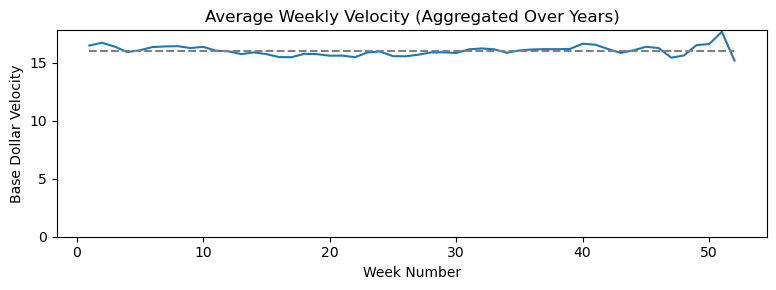

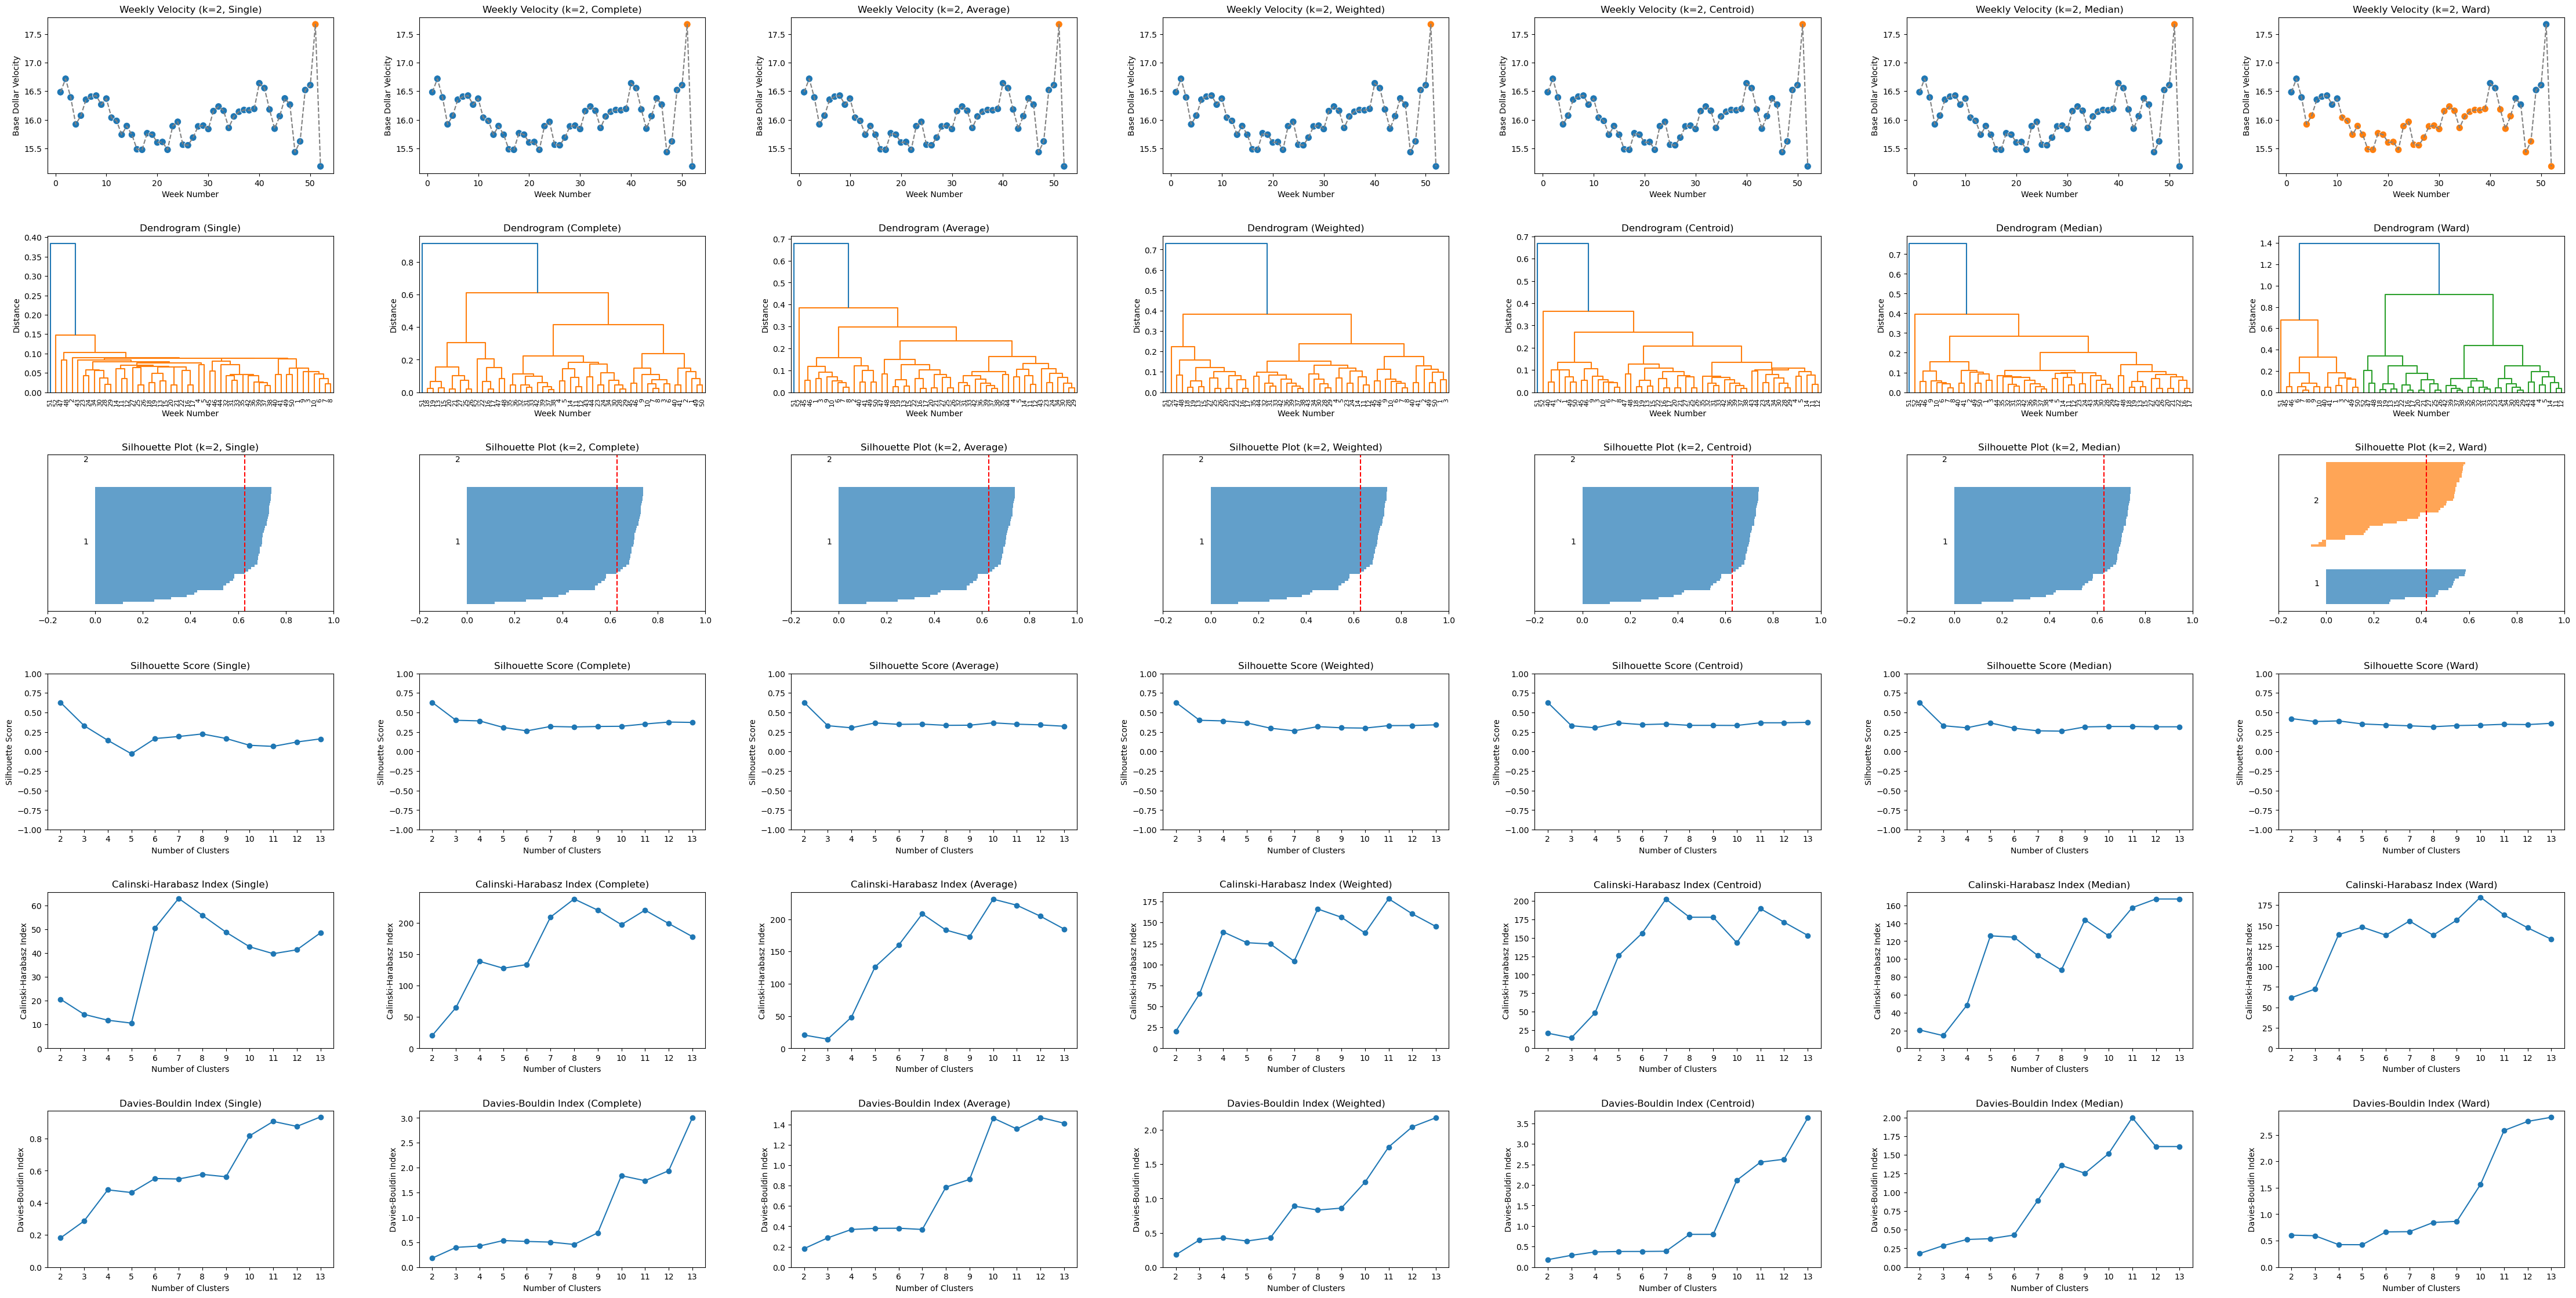

single: K being compared = 2, best alpha = 0.00, silhouette = 0.7176
complete: K being compared = 2, best alpha = 0.00, silhouette = 0.7176
average: K being compared = 2, best alpha = 0.00, silhouette = 0.7176
weighted: K being compared = 2, best alpha = 0.00, silhouette = 0.7176
centroid: K being compared = 2, best alpha = 0.00, silhouette = 0.7176
median: K being compared = 2, best alpha = 0.00, silhouette = 0.7176
ward: K being compared = 13, best alpha = 0.00, silhouette = 0.6526


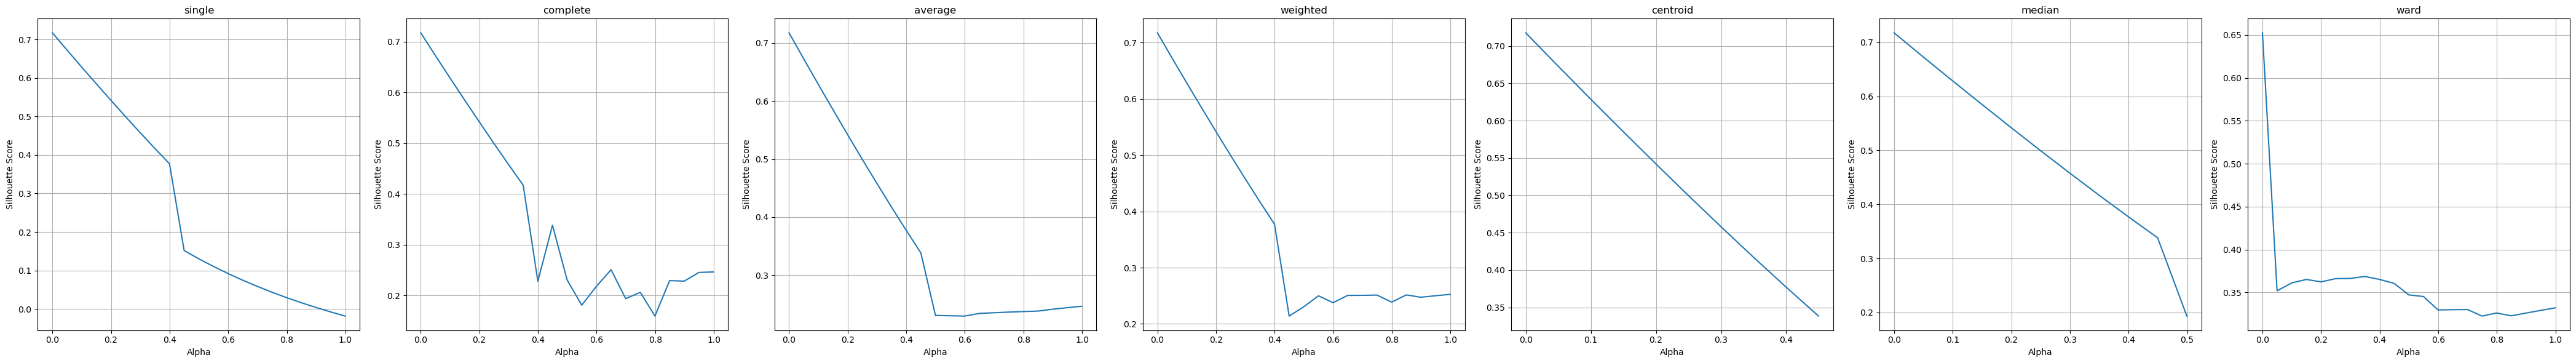

In [10]:
chomps_data_relabeled = standardize_columns(chomps_data, date="Time Period End Date", geo="Geography", base_dollars="Base Dollars", stores_selling="# of Stores Selling", acv="Max % ACV", product="Description")
weekly_velocity = calculate_weekly_velocity(chomps_data_relabeled, chomps_week_lkup, account, date(2022, 3), date(2025, 3))
score_dict = compute_linkage_scores(weekly_velocity, linkage_methods, k_max=k_max, custom_distance=True, alpha=alpha, distance_fn=dist_exp_decay)
plot_clustering_pipeline(weekly_velocity, score_dict)
# metrics1, metrics2, metrics3 = create_score_grids(score_dict, k_max)
print_optimized_alpha(weekly_velocity, linkage_methods, print_each_alpha=False, k_max=k_max)

# Tru Fru (Medium Seasonality)

### Importing Files

In [11]:
filename = "TruFru Seasonality.xlsx"
sheetname = "data"
week_mapping_sheet_name = "trufru_week_lkup"
trufru_data = import_excel(filename, sheetname)
trufru_week_lkup = import_excel(week_mapping_name, week_mapping_sheet_name)
trufru_data.head(3)

Geography                                            Product  \
0  Total US - Food  TRU FRU FROZEN ASSORTED BANANA FRUIT CONTAINER...   
1  Total US - Food  TRU FRU FROZEN ASSORTED BANANA FRUIT CONTAINER...   
2  Total US - Food  TRU FRU FROZEN ASSORTED BANANA FRUIT CONTAINER...   

                   Time  Dollar Sales  Dollar Sales Year Ago  Unit Sales  \
0  Week Ending 01-02-22   2069.086089                    NaN  403.125580   
1  Week Ending 01-09-22   2818.753394                    NaN  551.581494   
2  Week Ending 01-16-22   3158.118218                    NaN  614.071449   

   Unit Sales Year Ago  Base Dollar Sales  Base Dollar Sales Year Ago  \
0                  NaN        2069.086089                         NaN   
1                  NaN        2818.753394                         NaN   
2                  NaN        3154.850061                         NaN   

   Base Unit Sales  Base Unit Sales Year Ago  ACV Weighted Distribution  \
0       403.125580                       NaN                   1.172577   
1       551.581494                       NaN                   1.382089   
2       612.920094                       NaN                   1.396668   

   Weeks in Distribution  Weeks in Distribution Year Ago  \
0                    1.0                             NaN   
1                    1.0                             NaN   
2                    1.0                             NaN   

   Number of Stores Selling  Number of Stores Selling Year Ago   .    OM Date  
0                280.860170                                NaN NaN 2022-01-02  
1                341.251656                                NaN NaN 2022-01-09  
2                345.646405                                NaN NaN 2022-01-16

### Running Pipeline

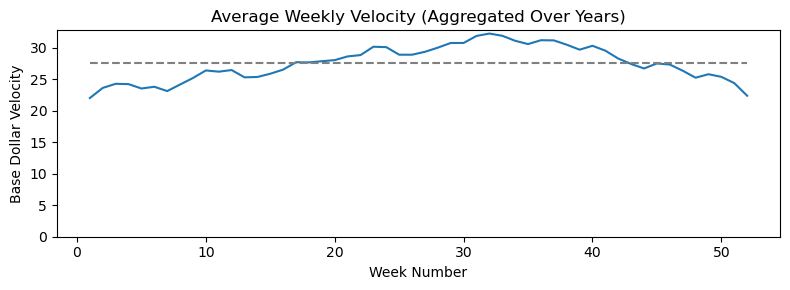

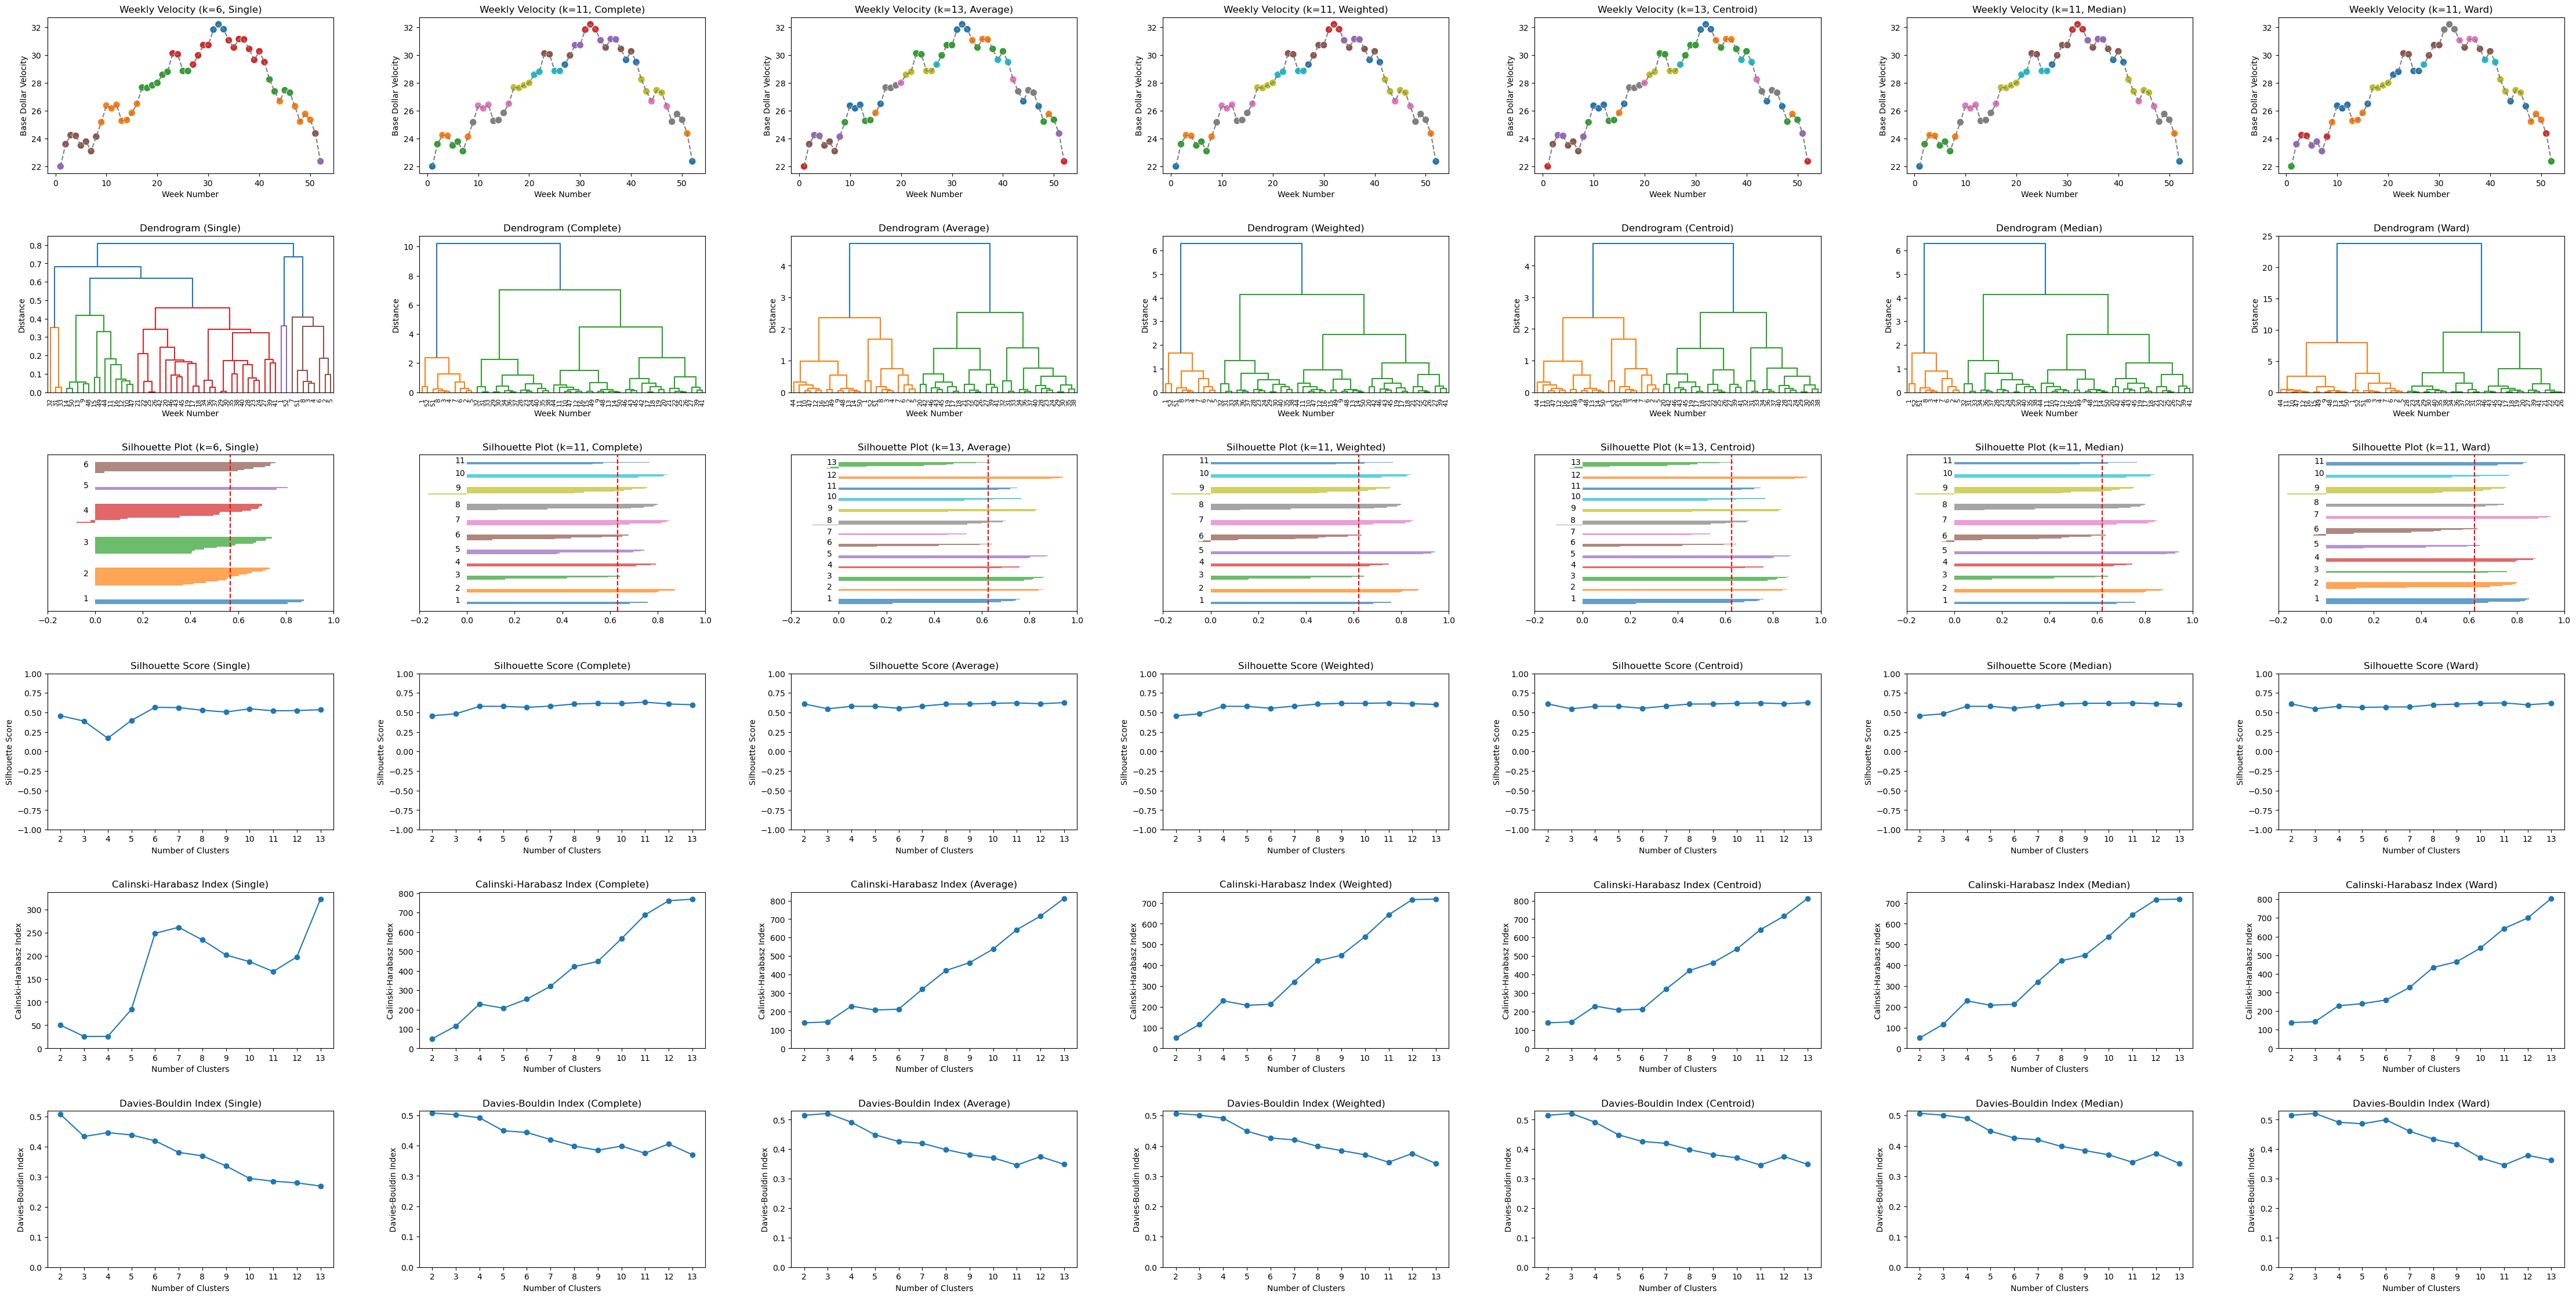

In [12]:
trufru_data_relabeled = standardize_columns(trufru_data, date="OM Date", geo="Geography", base_dollars="Base Dollar Sales", stores_selling="Number of Stores Selling", acv="ACV Weighted Distribution", product="Product")
weekly_velocity = calculate_weekly_velocity(trufru_data_relabeled, trufru_week_lkup, account, date(2022, year_beginning=True), date(2024, year_ending=True))
score_dict = compute_linkage_scores(weekly_velocity, linkage_methods, k_max=k_max, custom_distance=False)
plot_clustering_pipeline(weekly_velocity, score_dict)
# metrics1, metrics2, metrics3 = create_score_grids(score_dict, k_max)

### Including Time Dependency

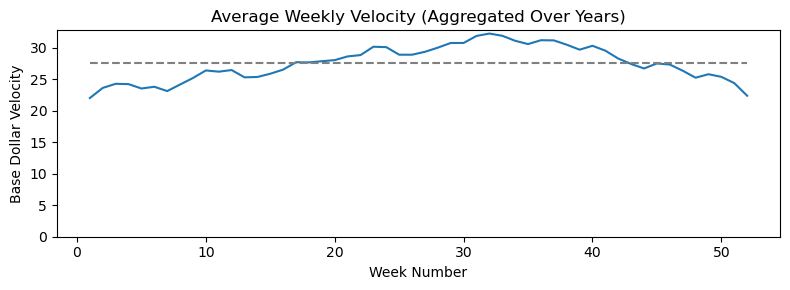

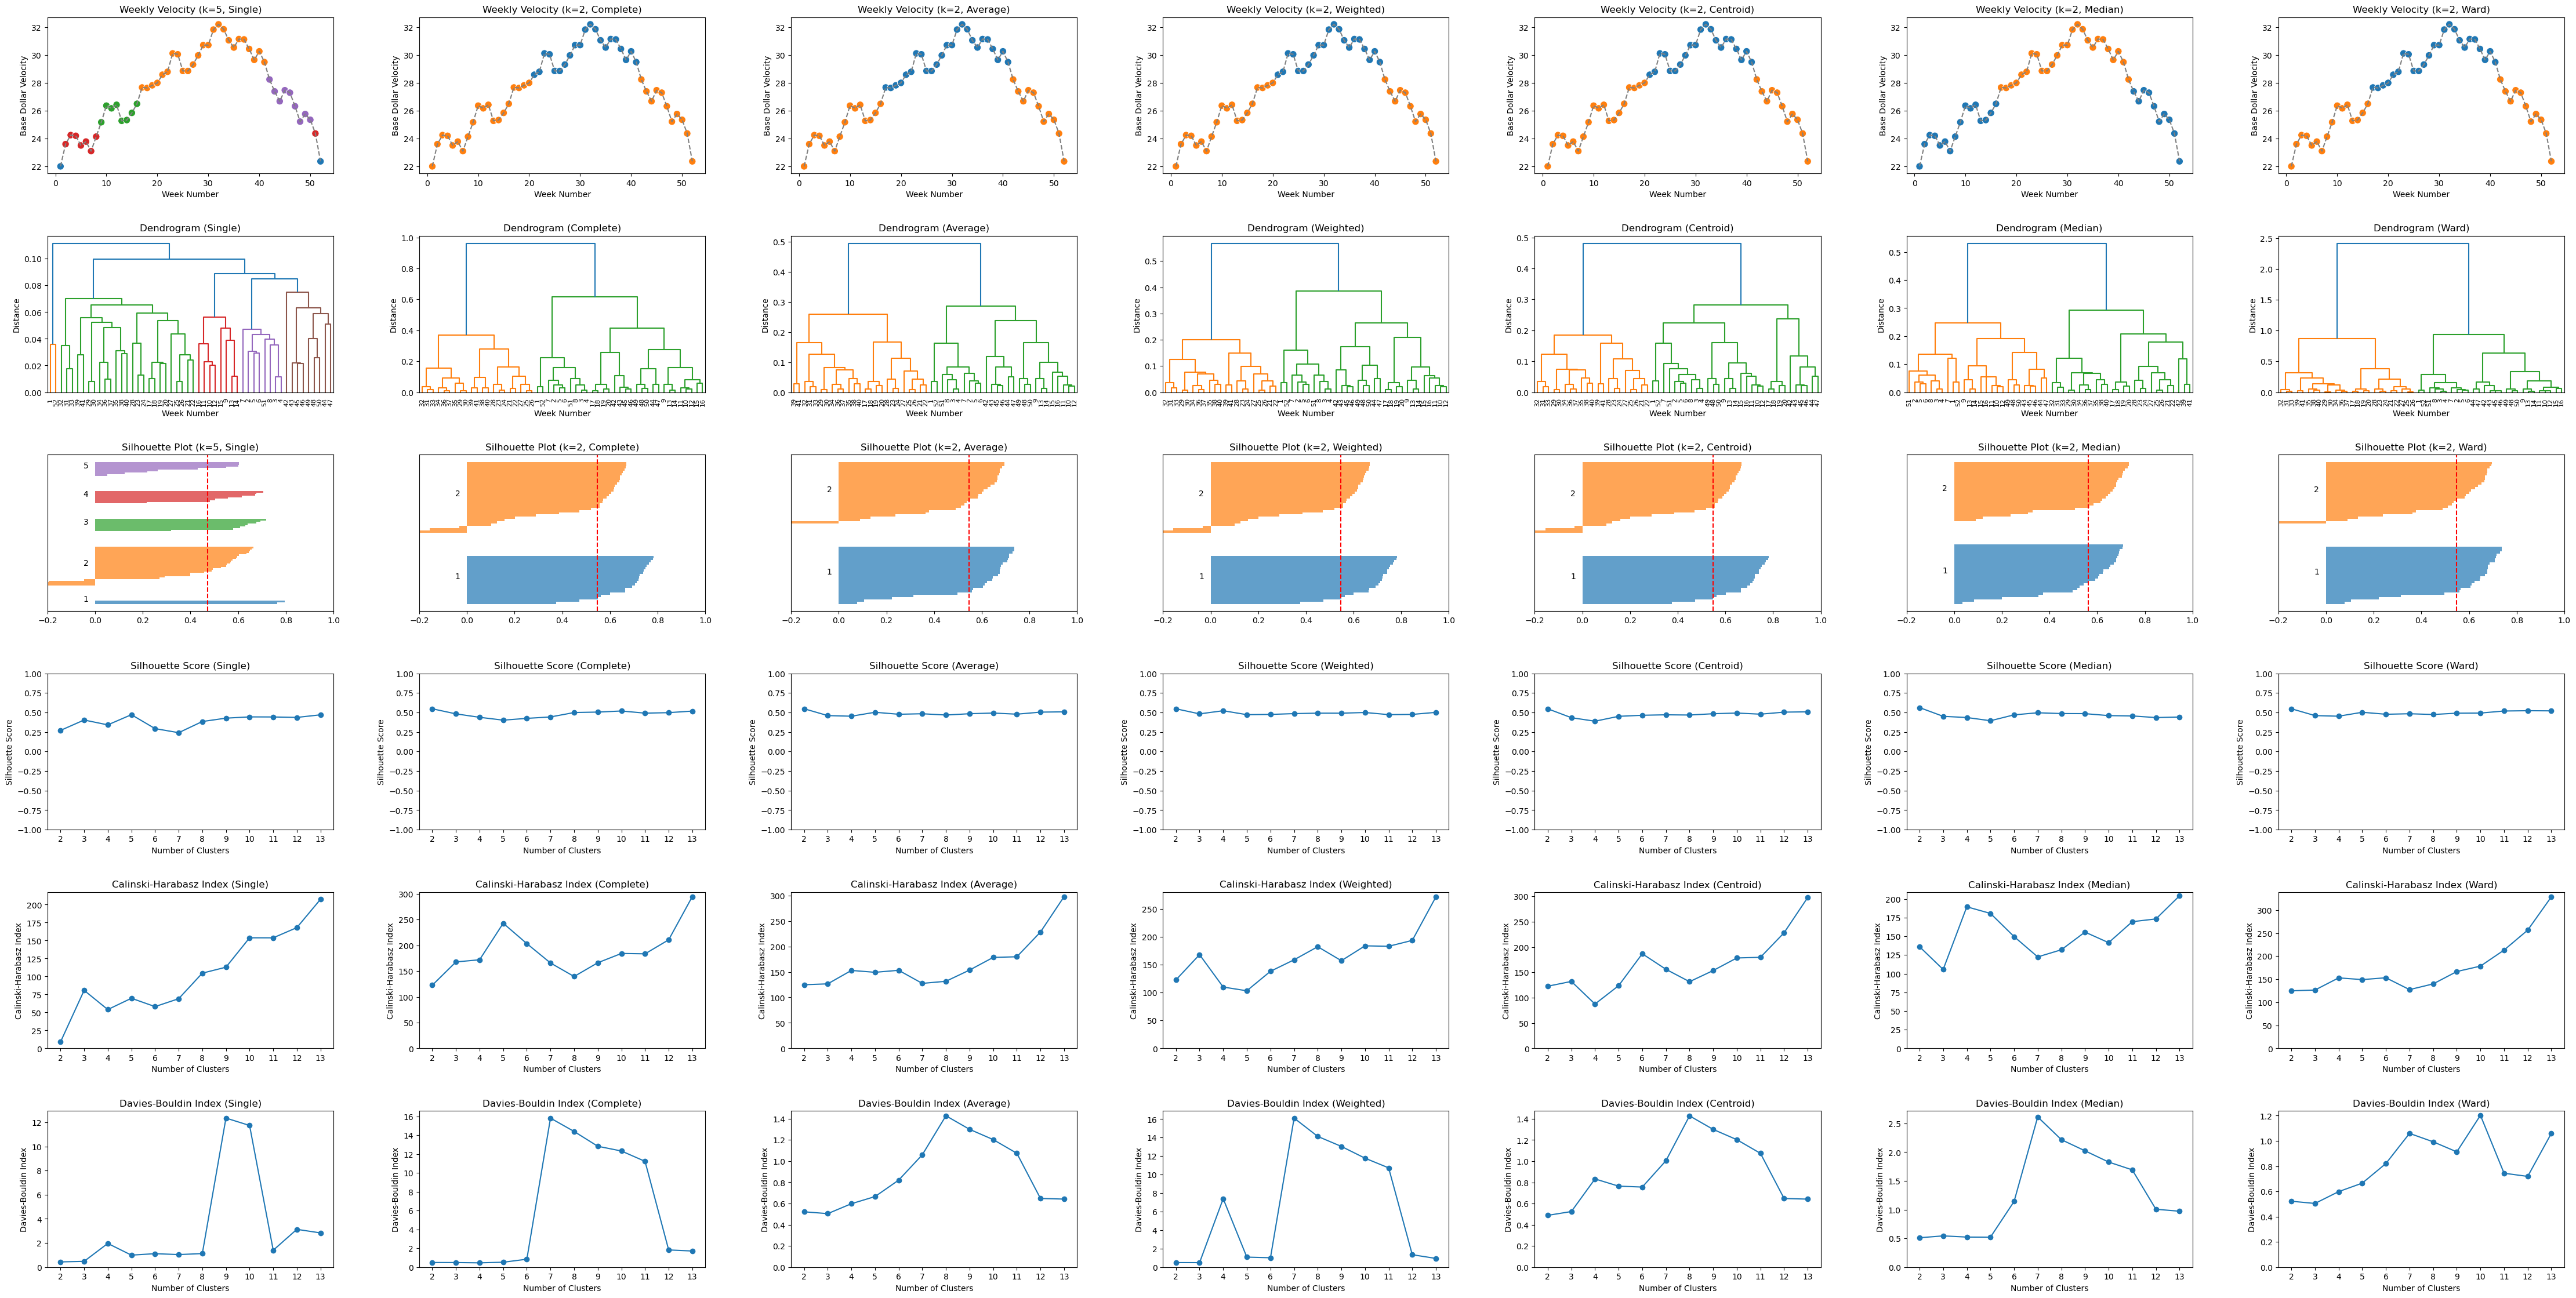

single: K being compared = 6, best alpha = 0.00, silhouette = 0.5660
complete: K being compared = 11, best alpha = 0.00, silhouette = 0.6321
average: K being compared = 13, best alpha = 0.00, silhouette = 0.6261
weighted: K being compared = 11, best alpha = 0.00, silhouette = 0.6222
centroid: K being compared = 13, best alpha = 0.00, silhouette = 0.6261
median: K being compared = 11, best alpha = 0.00, silhouette = 0.6222
ward: K being compared = 11, best alpha = 0.00, silhouette = 0.6222


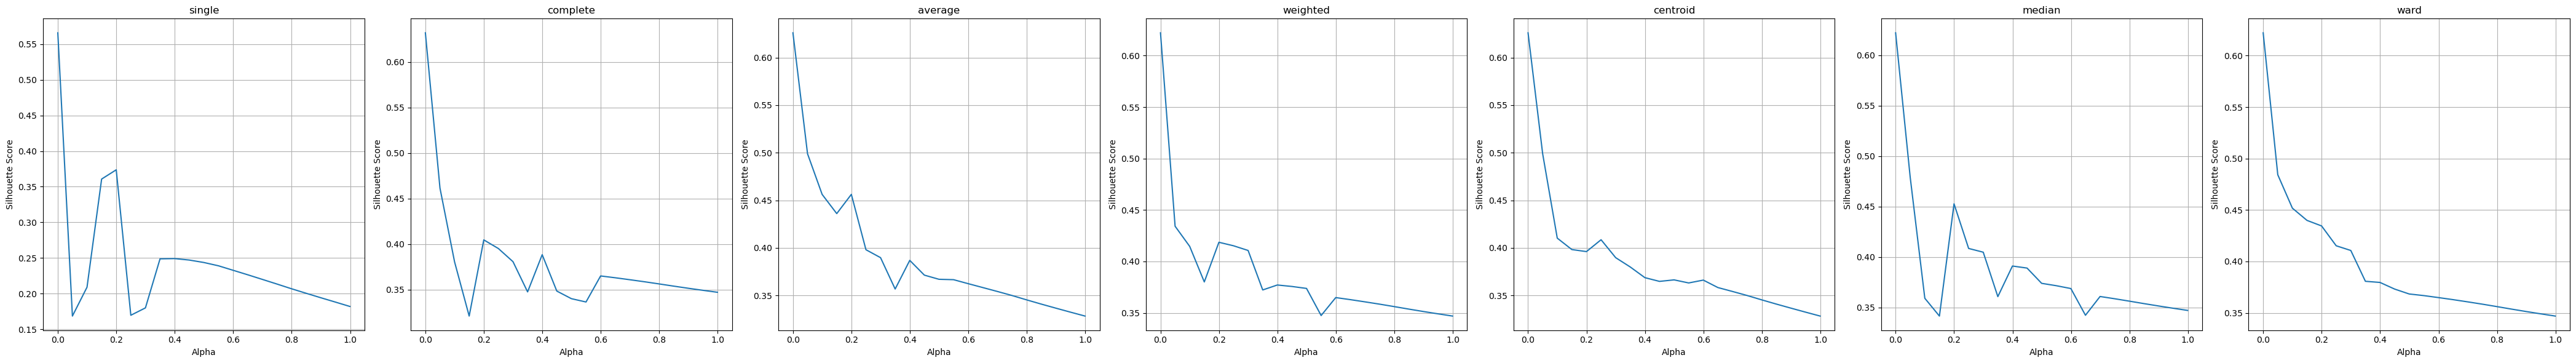

In [13]:
trufru_data_relabeled = standardize_columns(trufru_data, date="OM Date", geo="Geography", base_dollars="Base Dollar Sales", stores_selling="Number of Stores Selling", acv="ACV Weighted Distribution", product="Product")
weekly_velocity = calculate_weekly_velocity(trufru_data_relabeled, trufru_week_lkup, account, date(2022, year_beginning=True), date(2024, year_ending=True))
score_dict = compute_linkage_scores(weekly_velocity, linkage_methods, k_max=k_max, custom_distance=True, alpha=.2, distance_fn=dist_linear)
plot_clustering_pipeline(weekly_velocity, score_dict)
# metrics1, metrics2, metrics3 = create_score_grids(score_dict, k_max)
print_optimized_alpha(weekly_velocity, linkage_methods, print_each_alpha=False, k_max=k_max)

### Regression

#### Loading Data

In [14]:
# --- Trufu data w/ Baselines (Praytush) ---
filename = "TruFru Seasonality - Regressions.xlsx"
sheetname = "data"
week_mapping_sheet_name = "trufru_week_lkup"
trufu_w_baselines = import_excel(filename, sheetname)
trufru_week_lkup = import_excel(week_mapping_name, week_mapping_sheet_name)
display(trufu_w_baselines.head(3))

Geography                                            Product  \
0  ADUSA Corp-RMA - Food  TRU FRU FROZEN CHUNK PINEAPPLE FRUIT RESEALABL...   
1  ADUSA Corp-RMA - Food  TRU FRU FROZEN SLICED BANANA FRUIT RESEALABLE ...   
2  ADUSA Corp-RMA - Food  TRU FRU FROZEN WHOLE BLUEBERRY FRUIT RESEALABL...   

                   Time  Dollar.Sales   Unit.Sales  Base.Dollar.Sales  \
0  Week Ending 01-02-22   1156.070000   193.000000        1156.070000   
1  Week Ending 01-02-22   6547.108788  1093.006475        6547.108788   
2  Week Ending 01-02-22   1755.070000   293.000000        1755.070000   

   Base.Unit.Sales  ACV.Weighted.Distribution  \
0       193.000000                   6.866034   
1      1093.006475                  20.921225   
2       293.000000                   7.279188   

   ACV.Weighted.Distribution.Any.Merch  \
0                                  0.0   
1                                  0.0   
2                                  0.0   

   ACV.Weighted.Distribution.Price.Reductions.Only  \
0                                              0.0   
1                                              0.0   
2                                              0.0   

   ACV.Weighted.Distribution.Feature.Only  \
0                                     0.0   
1                                     0.0   
2                                     0.0   

   ACV.Weighted.Distribution.Display.Only  \
0                                     0.0   
1                                     0.0   
2                                     0.0   

   ACV.Weighted.Distribution.Feature.and.Display  Number.of.Stores.Selling  .  \
0                                            0.0                 83.040534  0   
1                                            0.0                273.134619  0   
2                                            0.0                 91.044441  0   

     OM.Date  Auto.Promo.Code  Auto.Base.Code  Auto.Base.Price  \
0 2022-01-02                1               0         6.405379   
1 2022-01-02                0               1         5.990000   
2 2022-01-02                1               0         6.409270   

   Auto.Base.Units  Auto.Base.Dollars  OM Account  Corp  Lower Channel  \
0       193.000000        1236.238207  ADUSA_CORP   1.0    0.0    Food   
1      1093.006475        6547.108788  ADUSA_CORP   1.0    0.0    Food   
2       293.000000        1877.916131  ADUSA_CORP   1.0    0.0    Food   

                                              OM SKU           OM PG  \
0  HC - Share 8oz - Pineapple White Chocolate and...  HC - Share 8oz   
1        HC - Share 8oz - Banana PB & Dark Chocolate  HC - Share 8oz   
2  HC - Share 8oz - Blueberry White & Dark Chocolate  HC - Share 8oz   

   Price Bucket Half Dollar  \
0                      6.49   
1                      5.99   
2                      6.49   

                                         Primary Key  Period (13)  END  
0  ADUSA Corp-RMA - FoodTRU FRU FROZEN CHUNK PINE...            1  NaN  
1  ADUSA Corp-RMA - FoodTRU FRU FROZEN SLICED BAN...            1  NaN  
2  ADUSA Corp-RMA - FoodTRU FRU FROZEN WHOLE BLUE...            1  NaN

#### Running Regression

In [28]:
sku = ["HC - Share 8oz - Strawberry White & Milk Chocolate"]
trufu_w_baselines_renamed = standardize_columns(trufu_w_baselines, date="OM.Date", stores_selling="Number.of.Stores.Selling", acv="ACV.Weighted.Distribution", channel_of_trade="Channel", product="OM SKU")
trufu_clustered_data = map_weeks_to_clusters(trufu_w_baselines_renamed, trufru_week_lkup, weekly_velocity, score_dict)
trufu_DI_no_season, trufu_model_no_season = run_price_factor_regression(trufu_clustered_data, sku, period_col_name="", date_min=date(2024, year_beginning=True), date_max=date(2024, year_ending=True))
trufu_DI, trufu_model = run_price_factor_regression(trufu_clustered_data, sku, period_col_name="Period (13)", date_min=date(2024, year_beginning=True), date_max=date(2024, year_ending=True))
trufu_DI_clustered, trufu_model_clustered = run_price_factor_regression(trufu_clustered_data, sku, period_col_name="Period Cluster", date_min=date(2024, year_beginning=True), date_max=date(2024, year_ending=True))
print("Demand Indices - No Period Factor")
display(trufu_DI_no_season)
print("Demand Indices - 13-Period Factor")
display(trufu_DI)
print("Demand Indices - Clustered Period Factor")
display(trufu_DI_clustered)
print(trufu_model_no_season.summary())
print(trufu_model.summary())
print(trufu_model_clustered.summary())


Constant price elasticity (log-log): -0.462
Constant price elasticity (log-log): -0.318
Constant price elasticity (log-log): -0.771
Demand Indices - No Period Factor


Price Percent of Base Units Demand Index
0  6.49                  1.2%         0.87
1  6.99                 25.0%         1.00
2  7.49                 11.4%         0.93
3  7.99                 31.1%         0.95
4  8.49                 10.3%         0.87
5  8.99                 20.9%         0.85

Demand Indices - 13-Period Factor


Price Percent of Base Units Demand Index
0  6.49                  1.2%         0.93
1  6.99                 25.0%         1.00
2  7.49                 11.4%         0.93
3  7.99                 31.1%         0.96
4  8.49                 10.3%         0.89
5  8.99                 20.9%         0.88

Demand Indices - Clustered Period Factor


Price Percent of Base Units Demand Index
0  6.49                  1.2%         0.90
1  6.99                 25.0%         1.00
2  7.49                 11.4%         0.90
3  7.99                 31.1%         0.91
4  8.49                 10.3%         0.82
5  8.99                 20.9%         0.79

                               OLS Regression Results                              
Dep. Variable:     np.log(Q('Base Units'))   R-squared:                       0.974
Model:                                 OLS   Adj. R-squared:                  0.973
Method:                      Least Squares   F-statistic:                     1120.
Date:                     Fri, 15 Aug 2025   Prob (F-statistic):               0.00
Time:                             12:11:11   Log-Likelihood:                 560.31
No. Observations:                     1840   AIC:                            -1001.
Df Residuals:                         1780   BIC:                            -669.6
Df Model:                               59                                         
Covariance Type:                 nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

# Martinelli's (High Seasonality)

### Importing Files

In [7]:
filename = "OM 251107 - Martinelli's for Seasonality.xlsx"
sheetname = "data"
week_mapping_sheet_name = "martinellis_week_lkup"
martinellis_data = import_excel(filename, sheetname)
martinellis_week_lkup = import_excel(week_mapping_name, week_mapping_sheet_name)
martinellis_data = martinellis_data.drop("END", axis=1)
martinellis_data.head(3)

Product        Geography  \
0  MARTINELLIS GOLD MEDAL APPLE CRANBERRY SPARKLI...  Total US - Food   
1  MARTINELLIS GOLD MEDAL APPLE CRANBERRY SPARKLI...  Total US - Food   
2  MARTINELLIS GOLD MEDAL APPLE CRANBERRY SPARKLI...  Total US - Food   

                   Time  Dollar Sales  Unit Sales  Base Dollar Sales  \
0  Week Ending 10-06-24    112.292695   19.007501         112.292695   
1  Week Ending 10-13-24   1040.204021  174.710244         689.721422   
2  Week Ending 10-20-24   1143.208949  191.726332         644.369480   

   Base Unit Sales  ACV Weighted Distribution  Number of Stores Selling   .  \
0        19.007501                   0.063652                 18.322156 NaN   
1       111.540104                   0.245889                 69.170491 NaN   
2       102.527081                   0.269972                 78.479840 NaN   

     OM Date  
0 2024-10-06  
1 2024-10-13  
2 2024-10-20

### Running Pipeline

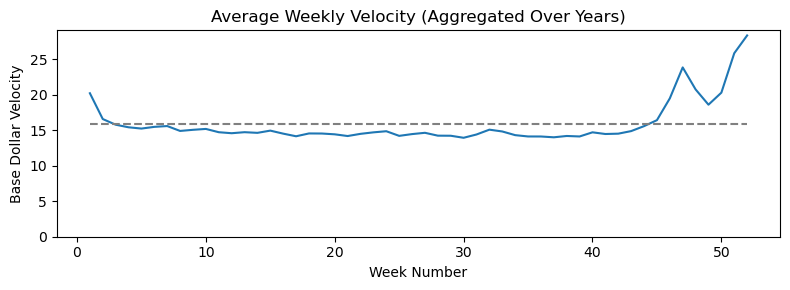

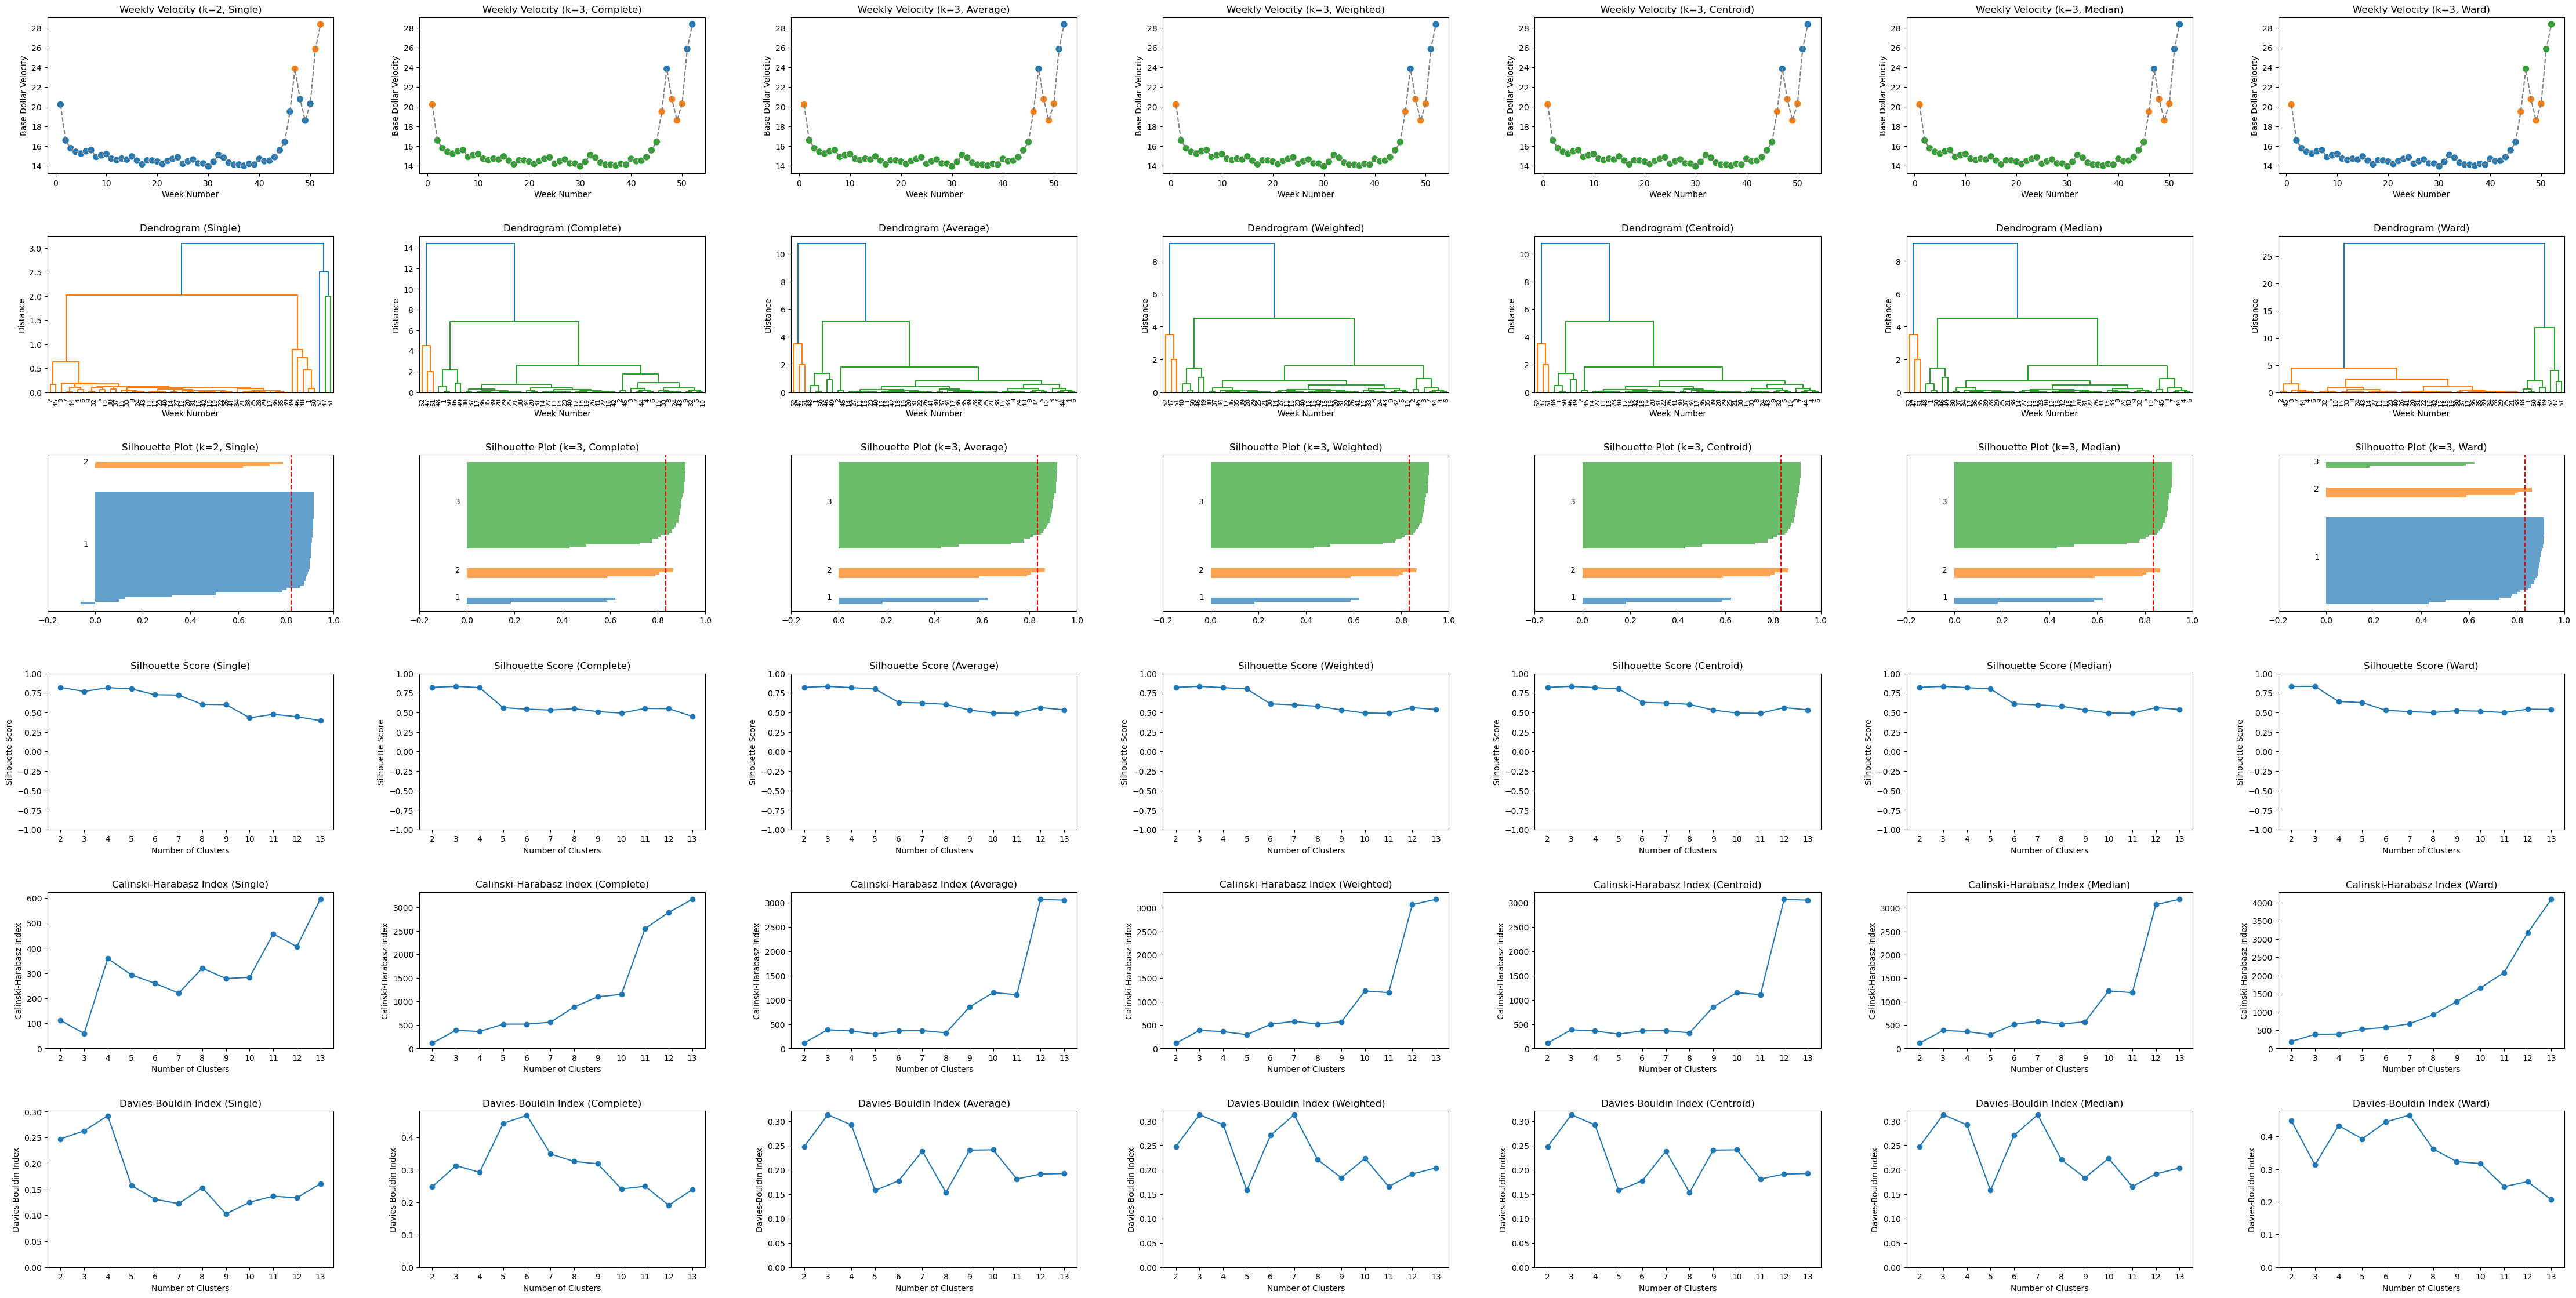

In [8]:
martinellis_data_relabeled = standardize_columns(martinellis_data, date="OM Date", geo="Geography", base_dollars="Base Dollar Sales", stores_selling="Number of Stores Selling", acv="ACV Weighted Distribution", product="Product")
weekly_velocity = calculate_weekly_velocity(martinellis_data_relabeled, martinellis_week_lkup, account, date(2022, year_beginning=True), date(2024, year_ending=True))
score_dict = compute_linkage_scores(weekly_velocity, linkage_methods, k_max=k_max, custom_distance=False)
plot_clustering_pipeline(weekly_velocity, score_dict)
# metrics1, metrics2, metrics3 = create_score_grids(score_dict, k_max)

### Including Time Dependency

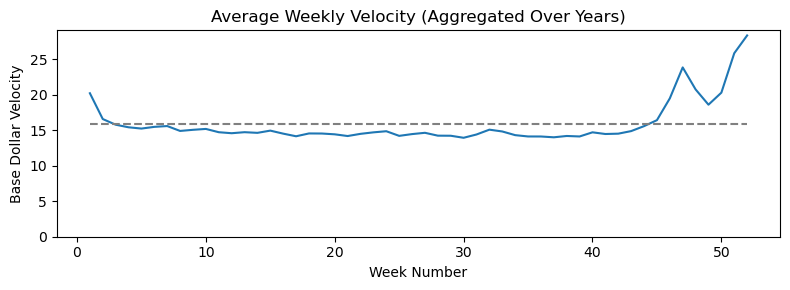

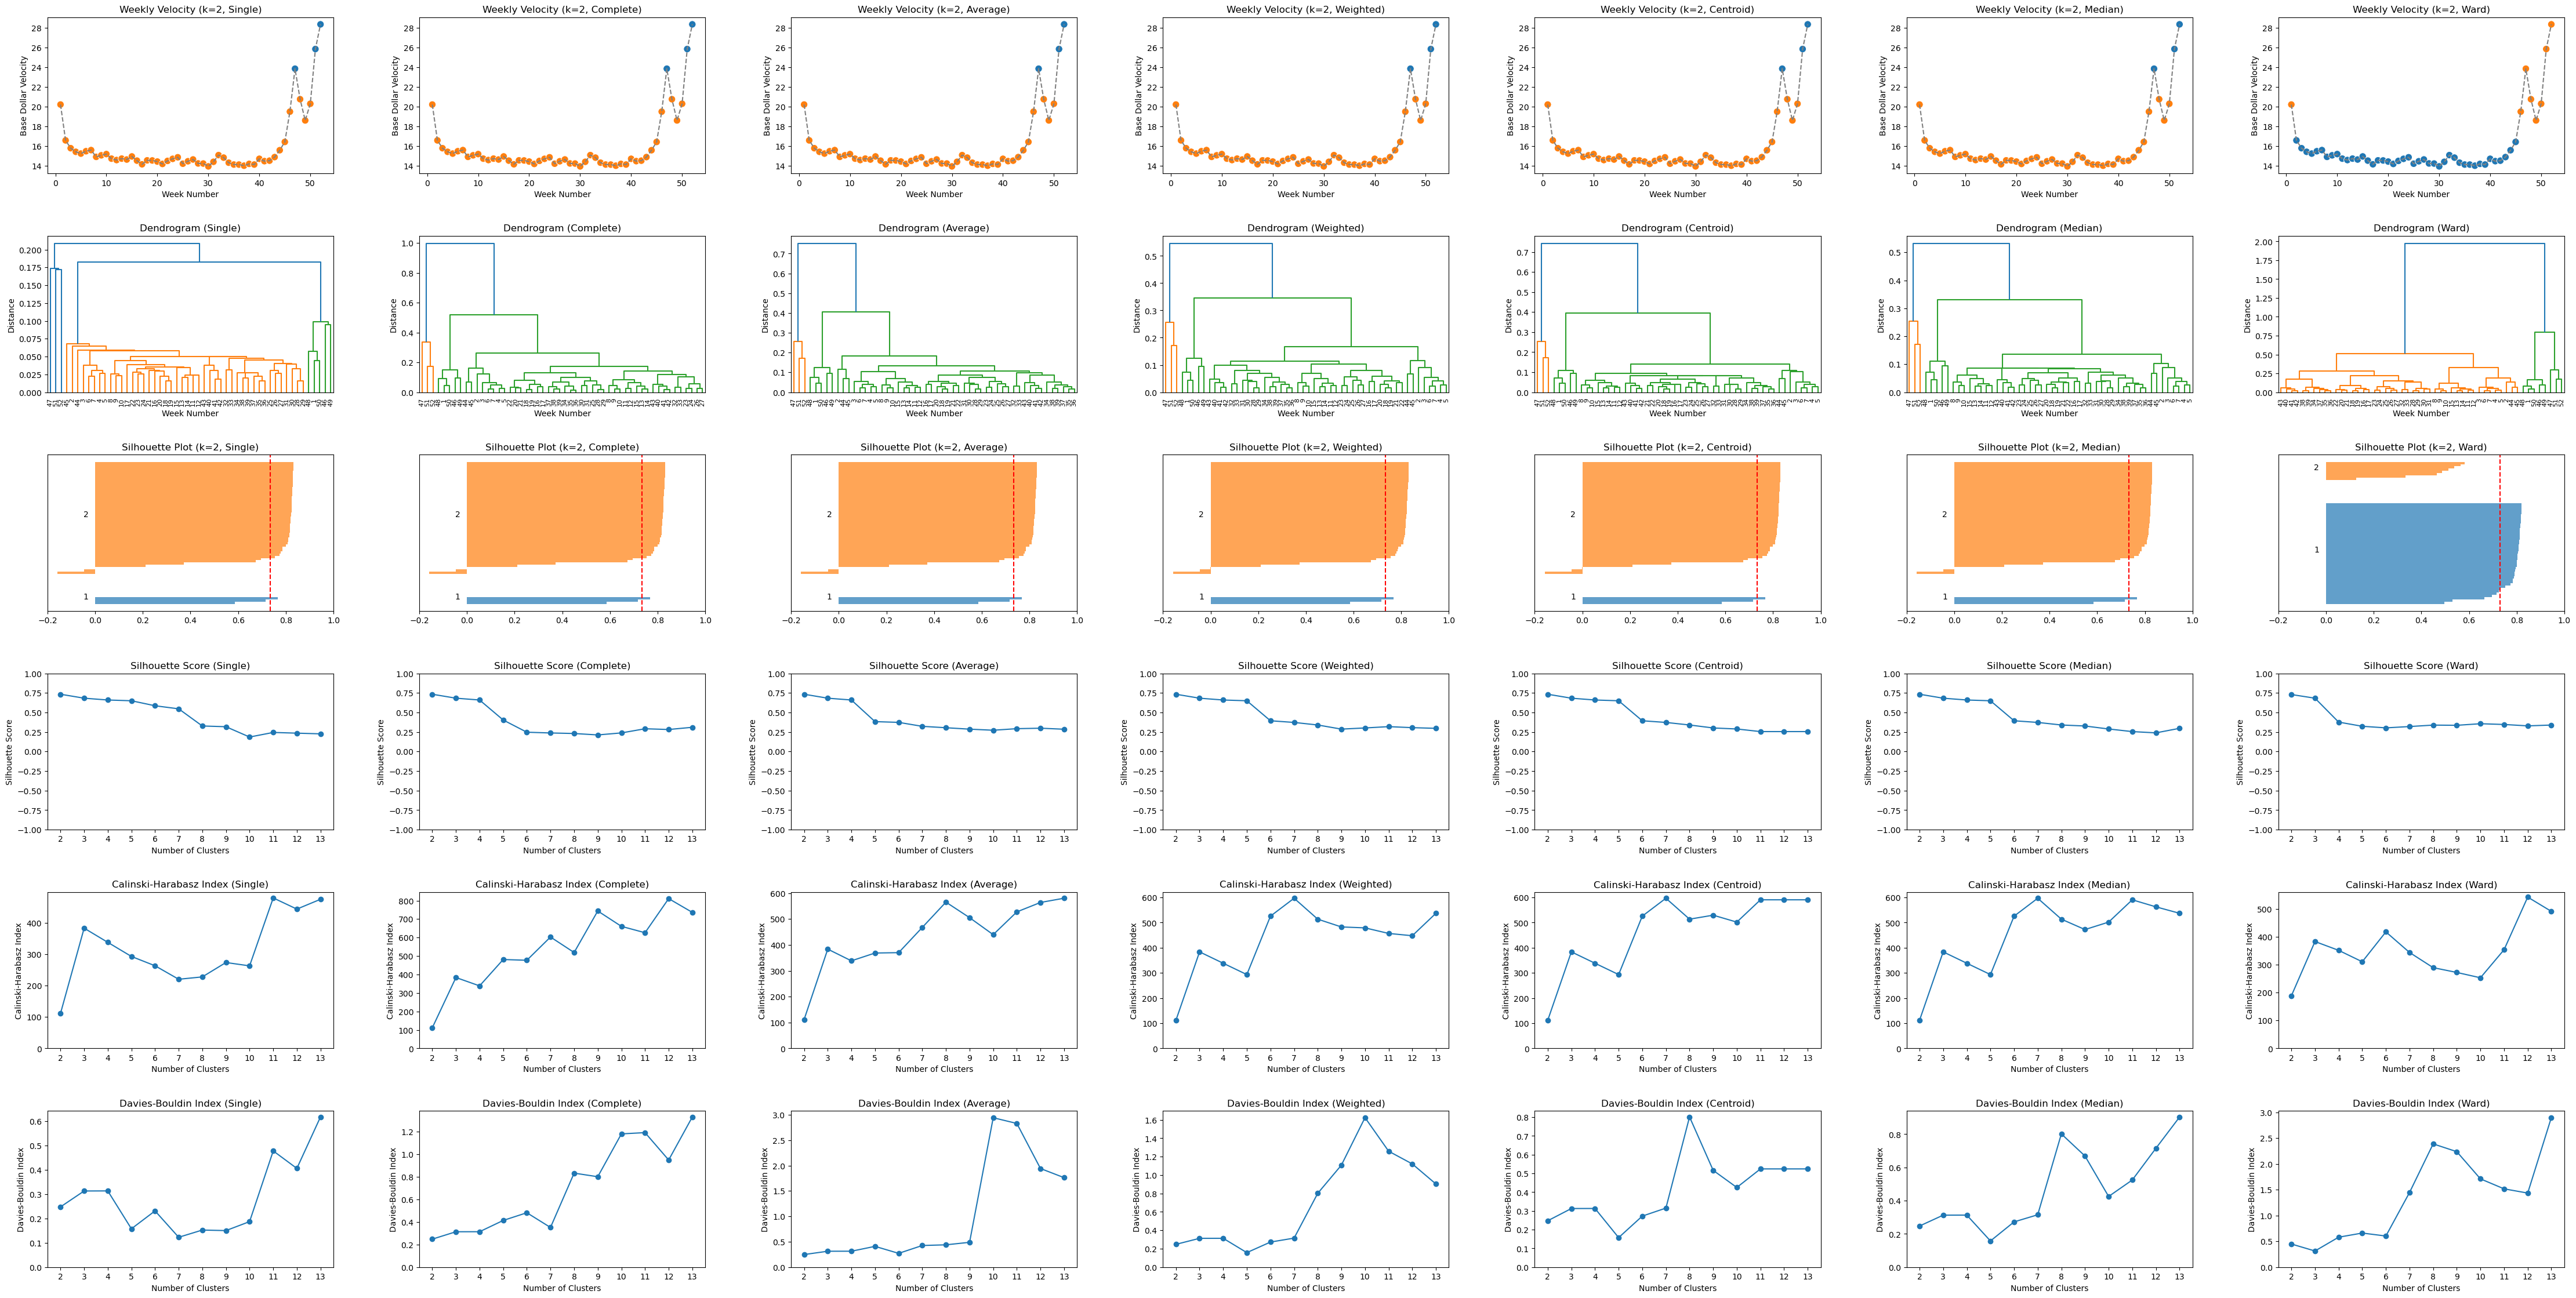

single: K being compared = 2, best alpha = 0.00, silhouette = 0.8221
complete: K being compared = 3, best alpha = 0.00, silhouette = 0.8342
average: K being compared = 3, best alpha = 0.00, silhouette = 0.8342
weighted: K being compared = 3, best alpha = 0.00, silhouette = 0.8342
centroid: K being compared = 3, best alpha = 0.00, silhouette = 0.8342
median: K being compared = 3, best alpha = 0.00, silhouette = 0.8342
ward: K being compared = 3, best alpha = 0.00, silhouette = 0.8342


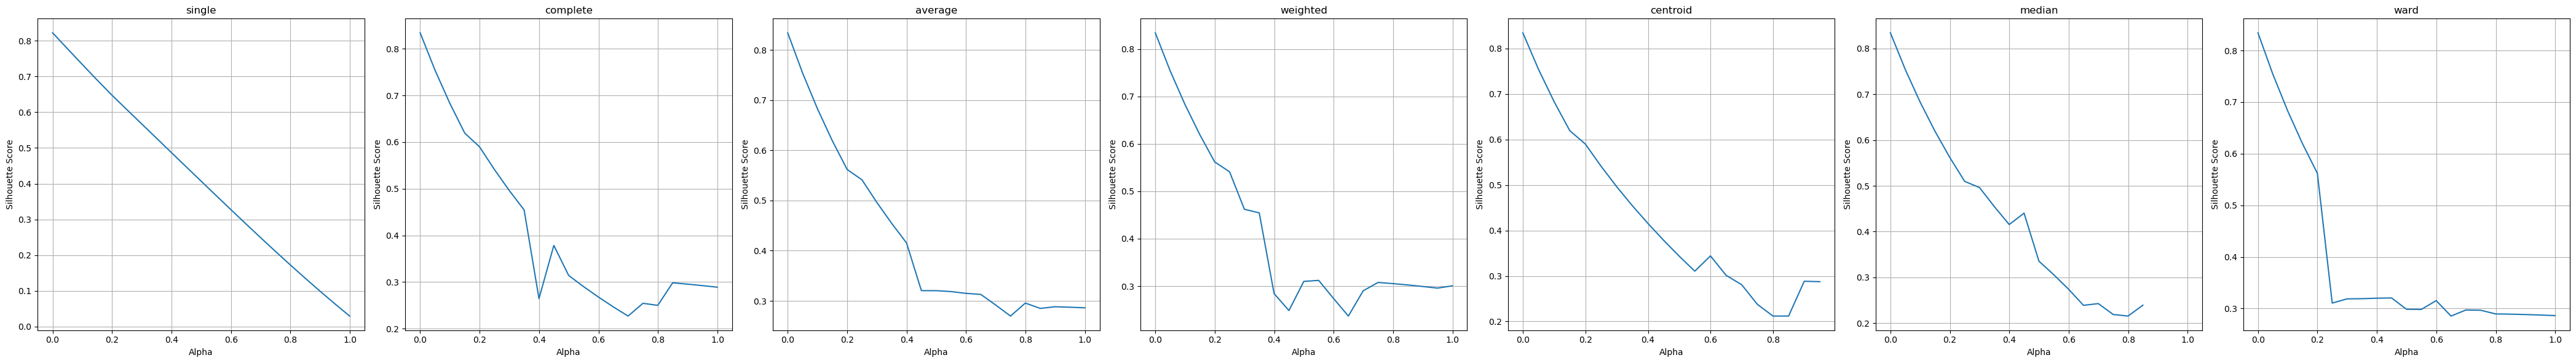

In [ ]:
martinellis_data_relabeled = standardize_columns(martinellis_data, date="OM Date", geo="Geography", base_dollars="Base Dollar Sales", stores_selling="Number of Stores Selling", acv="ACV Weighted Distribution", product="Product")
weekly_velocity = calculate_weekly_velocity(martinellis_data_relabeled, martinellis_week_lkup, account, date(2022, year_beginning=True), date(2024, year_ending=True))
score_dict = compute_linkage_scores(weekly_velocity, linkage_methods, k_max=k_max, custom_distance=True, alpha=alpha)
plot_clustering_pipeline(weekly_velocity, score_dict)
# metrics1, metrics2, metrics3 = create_score_grids(score_dict, k_max)
print_optimized_alpha(weekly_velocity, linkage_methods, print_each_alpha=False, k_max=k_max)

### Regression

#### Loading Data

In [10]:
# --- Martinelli's data w/ Baselines (Praytush) ---
filename = "Martinelli's Seasonality - Regressions.xlsx"
sheetname = "data"
week_mapping_sheet_name = "martinellis_week_lkup"
martinellis_w_baselines = import_excel(filename, sheetname)
martinellis_week_lkup = import_excel(week_mapping_name, week_mapping_sheet_name)
martinellis_w_baselines.head(3)

Product  \
0  MARTINELLIS APPLE POMEGRANATE SPARKLING JUICE ...   
1  MARTINELLIS APPLE POMEGRANATE SPARKLING JUICE ...   
2  MARTINELLIS APPLE POMEGRANATE SPARKLING JUICE ...   

                             Geography                  Time  Dollar.Sales  \
0        AlbertsonsCo Corp-CRMA - Food  Week Ending 01-10-21     41.926973   
1  AlbertsonsCo NorCal Div-CRMA - Food  Week Ending 01-10-21     43.168574   
2                  KR Corp-CRMA - Food  Week Ending 01-10-21     16.724470   

   Unit.Sales  Base.Dollar.Sales  Base.Unit.Sales  ACV.Weighted.Distribution  \
0   12.124556          41.926973        12.124556                   0.132603   
1   12.479764          43.168574        12.479764                   1.392094   
2    4.792112          16.724470         4.792112                   0.062307   

   Number.of.Stores.Selling  .    OM.Date  Auto.Promo.Code  Auto.Base.Code  \
0                 13.316145  0 2021-01-10                1               0   
1                 16.788668  0 2021-01-10                1               0   
2                  6.097672  0 2021-01-10                1               0   

   Auto.Base.Price  Auto.Base.Units  Auto.Base.Dollars  \
0          4.19000         6.927375          29.025701   
1          4.19000         7.127308          29.863420   
2          4.12554         3.468389          14.308975   

                            OM Account  Lower  COT  Price Bucket Half Dollar  \
0                                  NaN    NaN  NaN                      3.99   
1  AlbertsonsCo NorCal Div-CRMA - Food   -1.0   -1                      3.99   
2                  KR Corp-CRMA - Food   -1.0   -1                      3.99   

   L52  Period (13)  END  
0    0            0  NaN  
1    0            0  NaN  
2    0            0  NaN

#### Running Regression

SKU  \
0  MARTINELLIS APPLE POMEGRANATE SPARKLING JUICE ...   

                       Geography                  Time  Dollar.Sales  \
0  AlbertsonsCo Corp-CRMA - Food  Week Ending 01-10-21     41.926973   

   Unit.Sales  Base.Dollar.Sales  Base.Unit.Sales       ACV  \
0   12.124556          41.926973        12.124556  0.132603   

   # of Stores Selling  .       Date  Promo Code  Auto.Base.Code  \
0            13.316145  0 2021-01-10           1               0   

   Auto.Base.Price  Base Units  Base Dollars OM Account  Lower  COT  \
0             4.19    6.927375     29.025701        NaN    NaN  NaN   

   Price Bucket  L52  Period (13)  END  Week Number  Period Cluster  
0          3.99    0            0  NaN          NaN             NaN

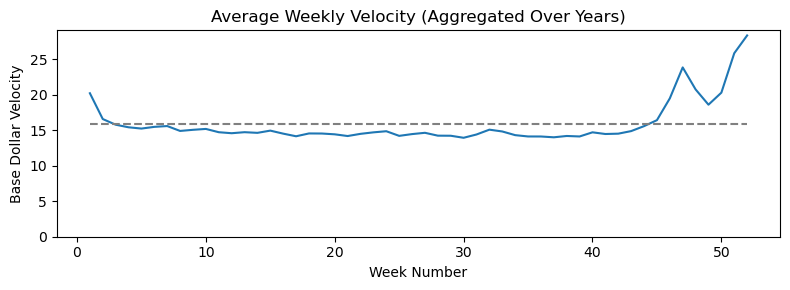

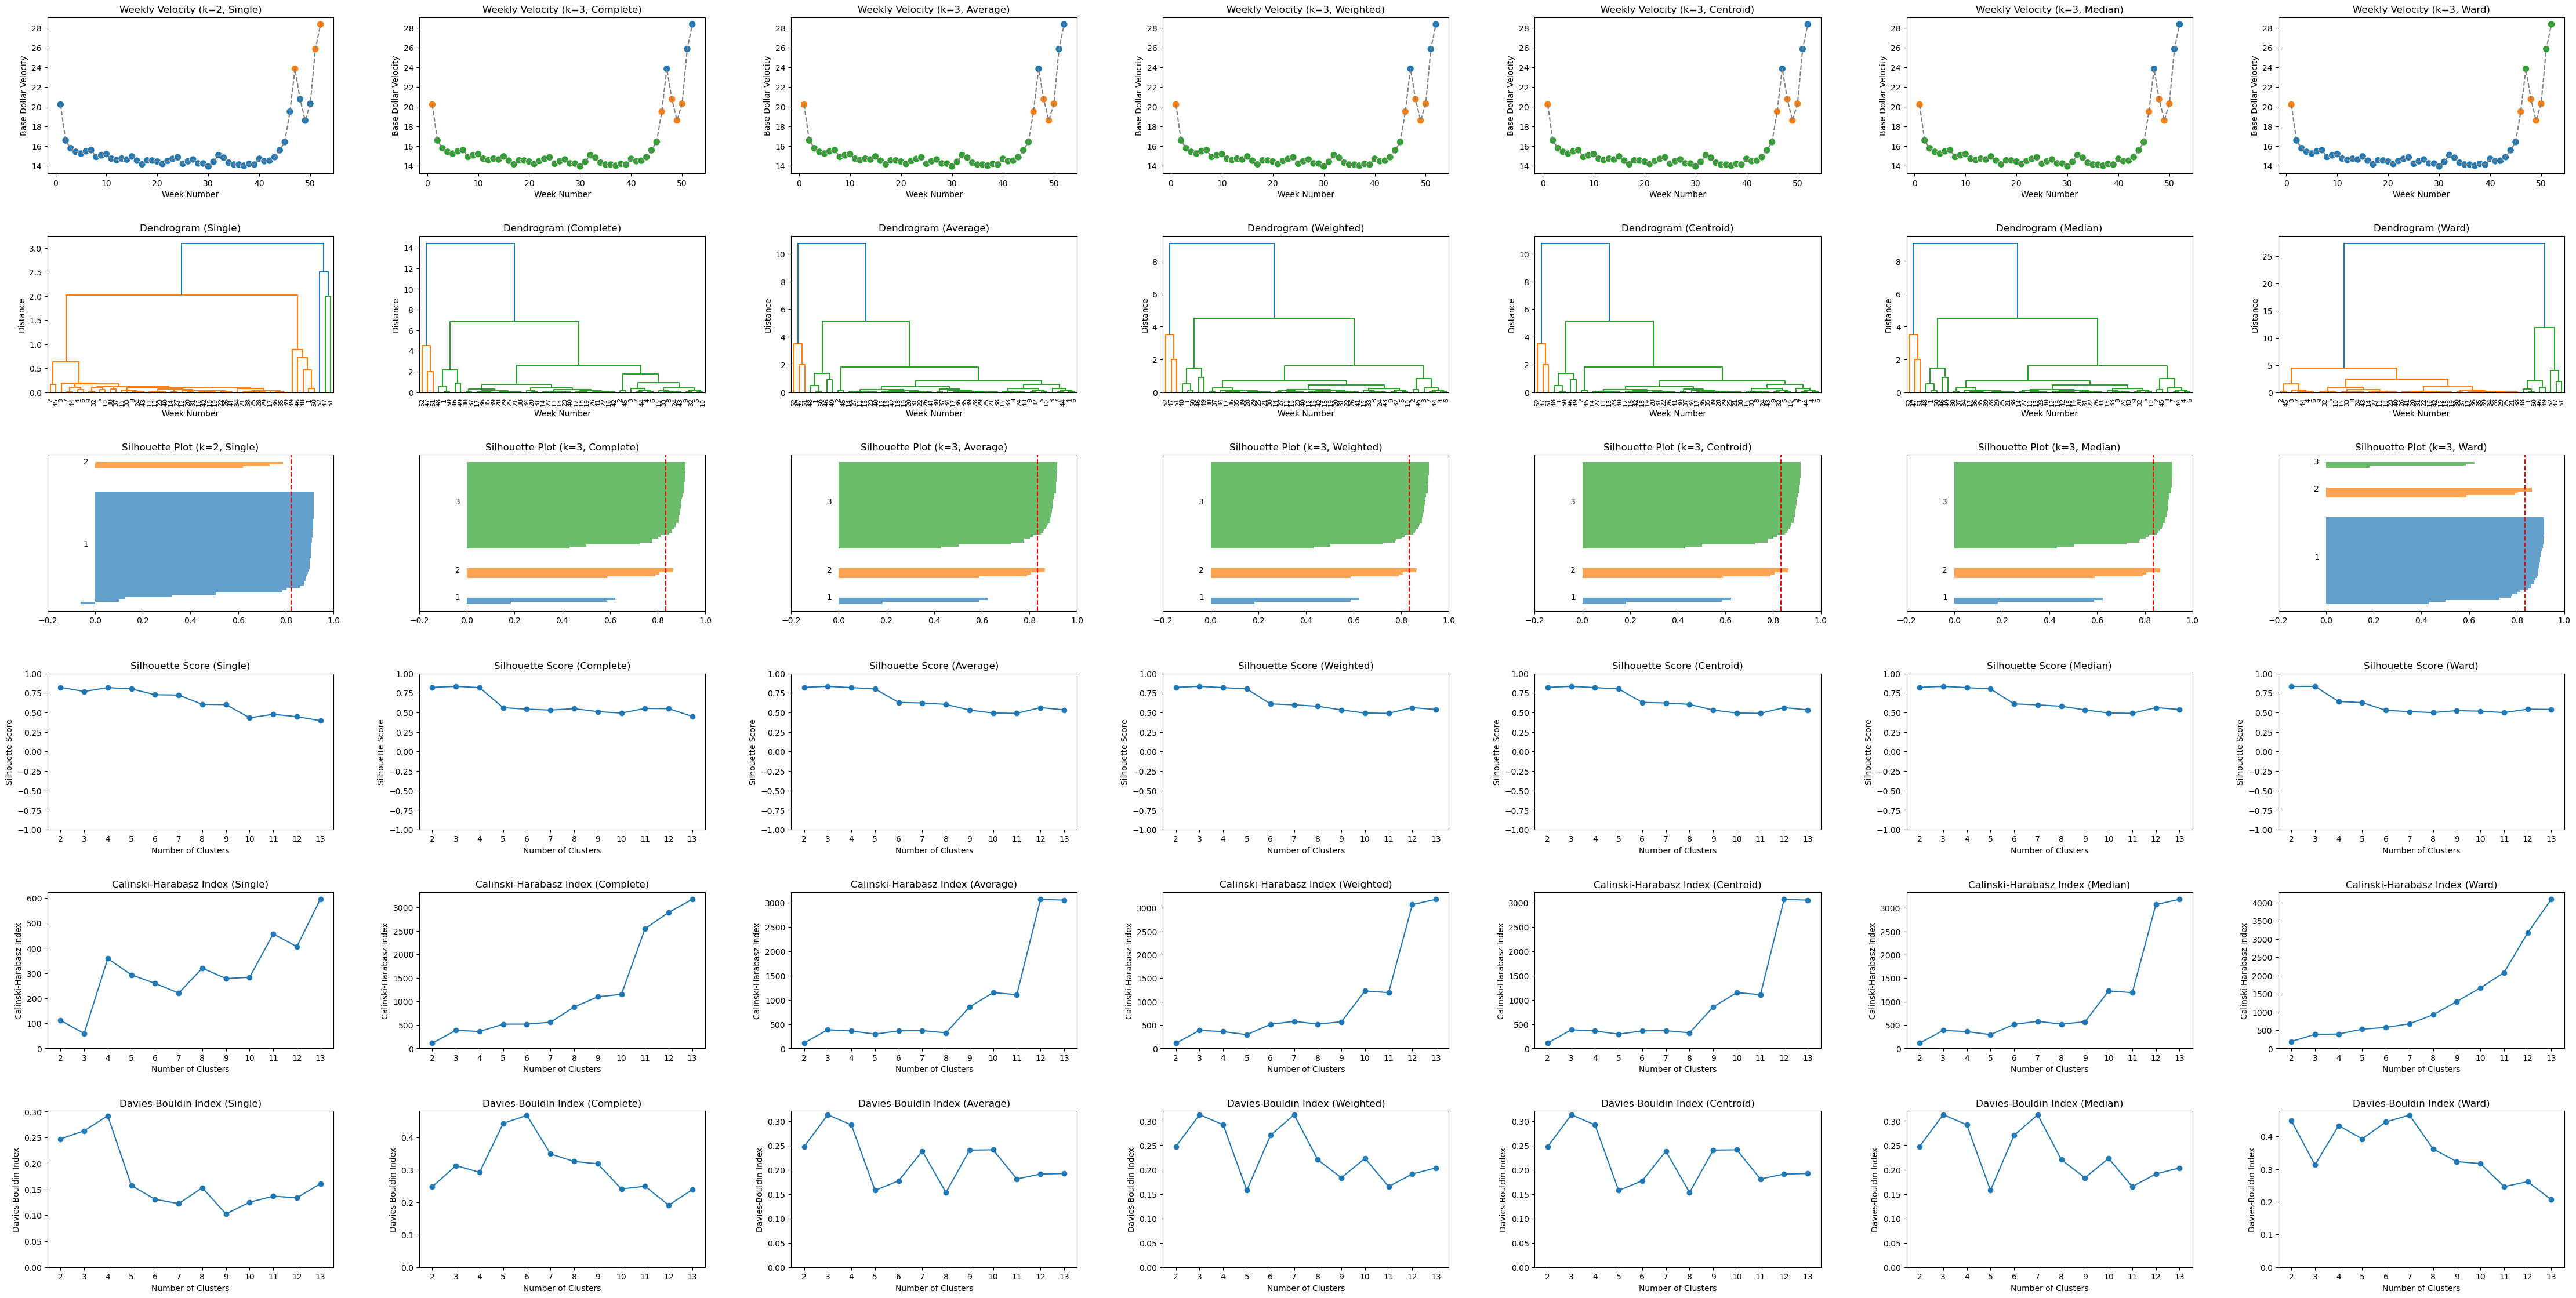

Constant price elasticity (log-log): -2.511
Constant price elasticity (log-log): -1.361
Constant price elasticity (log-log): -1.618


Price Percent of Base Units Demand Index
0  2.99                 16.0%         1.00
1  3.49                 49.0%         0.65
2  3.99                 19.8%         0.37
3  4.49                  6.7%         0.31
4  4.99                  5.5%         0.27
5  5.49                  3.0%         0.25

Price Percent of Base Units Demand Index
0  2.99                 16.0%         1.00
1  3.49                 49.0%         0.73
2  3.99                 19.8%         0.56
3  4.49                  6.7%         0.51
4  4.99                  5.5%         0.45
5  5.49                  3.0%         0.43

Price Percent of Base Units Demand Index
0  2.99                 16.0%         1.00
1  3.49                 49.0%         0.84
2  3.99                 19.8%         0.60
3  4.49                  6.7%         0.51
4  4.99                  5.5%         0.46
5  5.49                  3.0%         0.43


                                OLS Regression Results                              
Dep. Variable:     np.log(Q('Base Units'))   R-squared:                       0.834
Model:                                 OLS   Adj. R-squared:                  0.833
Method:                      Least Squares   F-statistic:                     546.9
Date:                     Wed, 20 Aug 2025   Prob (F-statistic):               0.00
Time:                             18:04:35   Log-Likelihood:                -5681.9
No. Observations:                     6905   AIC:                         1.149e+04
Df Residuals:                         6841   BIC:                         1.193e+04
Df Model:                               63                                         
Covariance Type:                 nonrobust                                         
                                                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [13]:
sku = ["MARTINELLIS GOLD MEDAL APPLE SPARKLING CIDER GLASS BOTTLE 1 CT 25.4 OZ - 0041244000062"]
date_min = date(2022, year_beginning=True)
date_max = date(2024, year_ending=True)
price_min = 2.99
price_max = 5.49

martinellis_w_baselines_renamed = standardize_columns(martinellis_w_baselines, date="OM.Date", stores_selling="Number.of.Stores.Selling", acv="ACV.Weighted.Distribution", channel_of_trade="Channel", period="Period (13)")
martinellis_clustered_data = map_weeks_to_clusters(martinellis_w_baselines_renamed, martinellis_week_lkup, weekly_velocity, score_dict, method="complete")
display(martinellis_clustered_data.head(1))
weekly_velocity = calculate_weekly_velocity(martinellis_data_relabeled, martinellis_week_lkup, account, date(2022, year_beginning=True), date(2024, year_ending=True))
score_dict = compute_linkage_scores(weekly_velocity, linkage_methods, k_max=k_max)
plot_clustering_pipeline(weekly_velocity, score_dict)
martinellis_DI_no_season, martinellis_model__no_season = run_price_factor_regression(martinellis_clustered_data, sku, period_col_name="", date_min=date_min, date_max=date_max, price_min=price_min, price_max=price_max)
martinellis_DI, martinellis_model = run_price_factor_regression(martinellis_clustered_data, sku, period_col_name="Period (13)", date_min=date_min, date_max=date_max, price_min=price_min, price_max=price_max)
martinellis_DI_clustered, martinellis_model_clustered = run_price_factor_regression(martinellis_clustered_data, sku, period_col_name="Period Cluster", date_min=date_min, date_max=date_max, price_min=price_min, price_max=price_max)
display(martinellis_DI_no_season)
display(martinellis_DI)
display(martinellis_DI_clustered)
print("\n", martinellis_model__no_season.summary())
print("\n", martinellis_model.summary())
print("\n", martinellis_model_clustered.summary())


### Plotting clustering overview for Martinelli's

(<Figure size 1200x800 with 2 Axes>,
 array([<Axes: title={'center': 'Velocity with 13-Period Bands'}, ylabel='Velocity'>,
        <Axes: title={'center': 'Velocity with Cluster Bands'}, xlabel='Week', ylabel='Velocity'>],
       dtype=object))

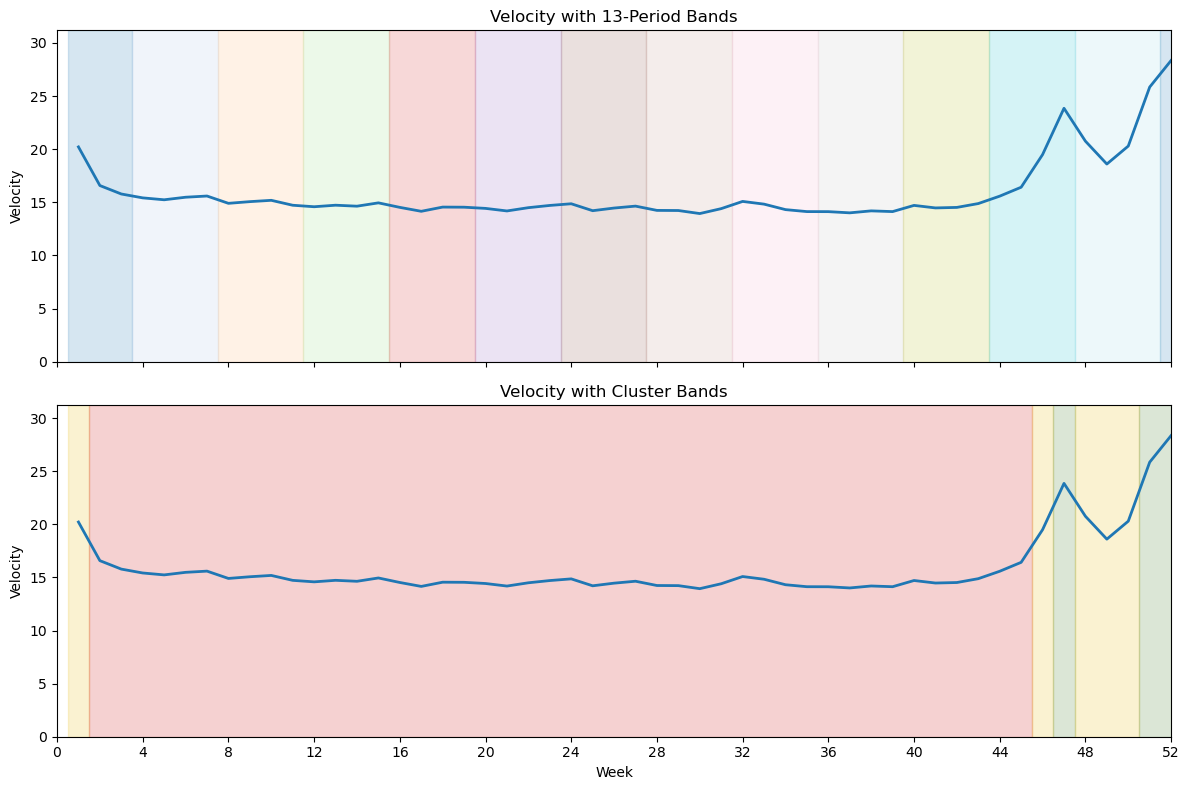

In [ ]:
# Messy functions and plotting for quick visual look at Martinelli's data clustering

velocity_martinellis = martinellis_clustered_data.merge(weekly_velocity, left_on="Week Number", right_on="Week Number", how="left")
def _first_available(colnames, options):
    for c in options:
        if c in colnames:
            return c
    return None

def _mode_or_nan(s):
    return s.value_counts().index[0] if s.size else np.nan

def _contiguous_runs(weeks, labels):
    runs = []
    if not weeks:
        return runs
    start = weeks[0]; prev_lab = labels[0]
    for w, lab in zip(weeks[1:], labels[1:]):
        if lab != prev_lab:
            runs.append((start, w-1, prev_lab))
            start = w; prev_lab = lab
    runs.append((start, weeks[-1], prev_lab))
    return runs

def _prepare_weekly(df, sku_list, date_min, date_max, week_col="Week Number", vel_col="Velocity"):
    sku_col = _first_available(df.columns, ["SKU","OM SKU","Description","Item","Product"])
    if sku_col is not None and sku_list is not None:
        df = df[df[sku_col].isin(sku_list)]
    date_col = _first_available(df.columns, ["Date","OM.Date","WE Date","Time Period End Date"])
    if date_col is not None:
        df = df[(pd.to_datetime(df[date_col]) >= pd.Timestamp(date_min)) & (pd.to_datetime(df[date_col]) <= pd.Timestamp(date_max))]
    if week_col not in df.columns:
        if date_col is None:
            raise ValueError("Week Number or a date column is required.")
        wknum = pd.to_datetime(df[date_col]).dt.isocalendar().week.astype(int)
        df = df.assign(**{week_col: wknum})
    if vel_col not in df.columns:
        raise ValueError("Velocity column not found.")
    wk = df.groupby(week_col, as_index=False)[vel_col].mean().rename(columns={vel_col:"Velocity"})
    wk[week_col] = wk[week_col].astype(int)
    wk = wk[(wk[week_col] >= 1) & (wk[week_col] <= 52)]
    weeks = sorted(wk[week_col].unique().tolist())
    return wk, weeks, week_col

def _label_per_week(df, week_col, label_col):
    if label_col not in df.columns:
        return pd.Series(dtype=object)
    return df.groupby(week_col)[label_col].agg(_mode_or_nan)

def _plot_with_bands(ax, wk_df, weeks, week_col, band_series, title, ylabel="Velocity", custom_color_map=None):
    ax.plot(wk_df[week_col], wk_df["Velocity"], linewidth=2)
    ax.set_xlim(1, 52)
    ymin = 0 if wk_df["Velocity"].min() >= 0 else wk_df["Velocity"].min()*1.05
    ymax = wk_df["Velocity"].max()*1.1 if wk_df["Velocity"].max() > 0 else 1
    ax.set_ylim(ymin, ymax)
    ax.set_xticks(list(range(0, 53, 4)))
    ax.set_xlabel("Week")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(False)
    if len(band_series) == 0:
        return
    band_series = band_series.reindex(weeks)
    if custom_color_map is not None:
        color_map = custom_color_map
    else:
        uniq = pd.unique(band_series.dropna())
        colors = plt.cm.tab20(np.linspace(0, 1, max(1, len(uniq))))
        color_map = {lab: colors[i % len(colors)] for i, lab in enumerate(uniq)}
    runs = _contiguous_runs(weeks, band_series.tolist())
    for start, end, lab in runs:
        if pd.isna(lab):
            continue
        ax.axvspan(start-0.5, end+0.5, color=color_map.get(lab, "#dddddd"), alpha=0.18, zorder=0)

def plot_velocity_periods_and_clusters(df, sku_list, date_min, date_max,
                                       period_col="Period (13)", cluster_col="Period Cluster",
                                       week_col="Week Number", vel_col="Velocity"):
    wk_df, weeks, week_col = _prepare_weekly(df, sku_list, date_min, date_max, week_col, vel_col)
    period_by_week = _label_per_week(df, week_col, period_col)
    cluster_by_week = _label_per_week(df, week_col, cluster_col)

    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    _plot_with_bands(axes[0], wk_df, weeks, week_col, period_by_week, "Velocity with 13-Period Bands")
    axes[0].set_xlabel("")

    if len(cluster_by_week) > 0:
        tmp = pd.DataFrame({week_col: weeks}).merge(cluster_by_week.rename("cluster"), left_on=week_col, right_index=True, how="left") \
                                             .merge(wk_df[[week_col, "Velocity"]], on=week_col, how="left")
        cluster_means = tmp.dropna(subset=["cluster"]).groupby("cluster")["Velocity"].mean().sort_values()
        rank_colors = ["#cc0000", "#e6b800", "#38761d"]
        color_map_custom = {cl: rank_colors[i % len(rank_colors)] for i, cl in enumerate(cluster_means.index)}
    else:
        color_map_custom = None

    _plot_with_bands(axes[1], wk_df, weeks, week_col, cluster_by_week, "Velocity with Cluster Bands", custom_color_map=color_map_custom)
    axes[1].set_xlabel("Week")

    fig.tight_layout()
    return fig, axes

plot_velocity_periods_and_clusters(
    velocity_martinellis,
    sku,
    date_min,
    date_max,
    period_col="Period (13)",
    cluster_col="Period Cluster",
    week_col="Week Number",
    vel_col="Velocity"
)

# Other Datasets

## Gavina

#### Loading Data

In [34]:
# --- Gavina data w/ Baselines (Praytush) ---
filename = "Gavina Seasonality - Regression.xlsx"
sheetname = "data"
week_mapping_sheet_name = "martinellis_week_lkup"
gavina_w_baselines = import_excel(filename, sheetname)
gavina_week_lkup = import_excel(week_mapping_name, week_mapping_sheet_name)
gavina_w_baselines.head(3)

Geography                                            Product  \
0  Total US - Food  DON FRANCISCO'S GROUND MULTI SERVE COFFEE BAG ...   
1  Total US - Food  DON FRANCISCO'S GROUND MULTI SERVE COFFEE BAG ...   
2  Total US - Food  DON FRANCISCO'S GROUND MULTI SERVE COFFEE BAG ...   

                   Time  Dollar Sales  Unit Sales  Base Dollar Sales  \
0  Week Ending 05-28-23   3194.477435  455.727448        2745.191238   
1  Week Ending 06-04-23   3535.002553  547.601141        2206.720558   
2  Week Ending 06-11-23   2609.169793  378.204656        2330.876536   

   Base Unit Sales  ACV Weighted Distribution  \
0       365.428504                   0.708119   
1       307.664602                   0.736481   
2       323.776367                   0.668913   

   ACV Weighted Distribution Any Merch  Weeks in Distribution  \
0                             0.376275                      1   
1                             0.500815                      1   
2                             0.289857                      1   

   Number of Stores Selling   .       OM Account    COT          ACVMM  Corp  \
0                326.412681 NaN  Total US - Food  Total  809539.491337     0   
1                275.163629 NaN  Total US - Food  Total  809539.491337     0   
2                289.943429 NaN  Total US - Food  Total  809539.491337     0   

   Lower    OM Date OM Quad Date  Period          UPC OM Product Group  \
0      0 2023-05-28   2023-06-18       6  72323048711        DFFR_Bags   
1      0 2023-06-04   2023-06-18       6  72323048711        DFFR_Bags   
2      0 2023-06-11   2023-06-18       6  72323048711        DFFR_Bags   

                                             OM Name  List Price      COGS  \
0  Double French Ground Coffee Non Organic Foil B...         6.8  4.571062   
1  Double French Ground Coffee Non Organic Foil B...         6.8  4.571062   
2  Double French Ground Coffee Non Organic Foil B...         6.8  4.571062   

   Store Weeks  ACV >5  ACV >10       L52 L12  Manual Promo Coding  \
0   326.412681       0        0  L52 YAGO   0                    0   
1   275.163629       0        0  L52 YAGO   0                    1   
2   289.943429       0        0  L52 YAGO   0                    0   

                                         Primary Key  Quad ACV  \
0  Total US - FoodDON FRANCISCO'S GROUND MULTI SE...   1.19055   
1  Total US - FoodDON FRANCISCO'S GROUND MULTI SE...   1.19055   
2  Total US - FoodDON FRANCISCO'S GROUND MULTI SE...   1.19055   

   Quad ACV Any Merch  Quad Stores Selling  Auto Promo Coding  \
0            0.685658           530.052718                  1   
1            0.685658           530.052718                  1   
2            0.685658           530.052718                  1   

   Auto Base Price  Auto Base Units  Auto Base Dollars  Price Buckets Dollar  \
0         7.548705        263.18349        1986.694479                  7.99   
1         7.548705        263.18349        1986.694479                  7.99   
2         7.548705        263.18349        1986.694479                  7.99   

   Price Buckets Half Dollar  END  
0                       7.49  NaN  
1                       7.49  NaN  
2                       7.49  NaN

#### Running Regression

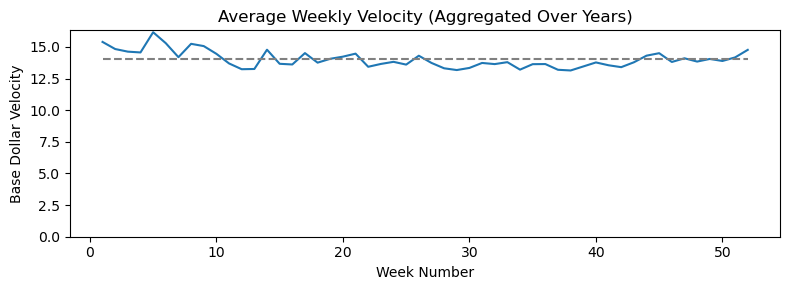

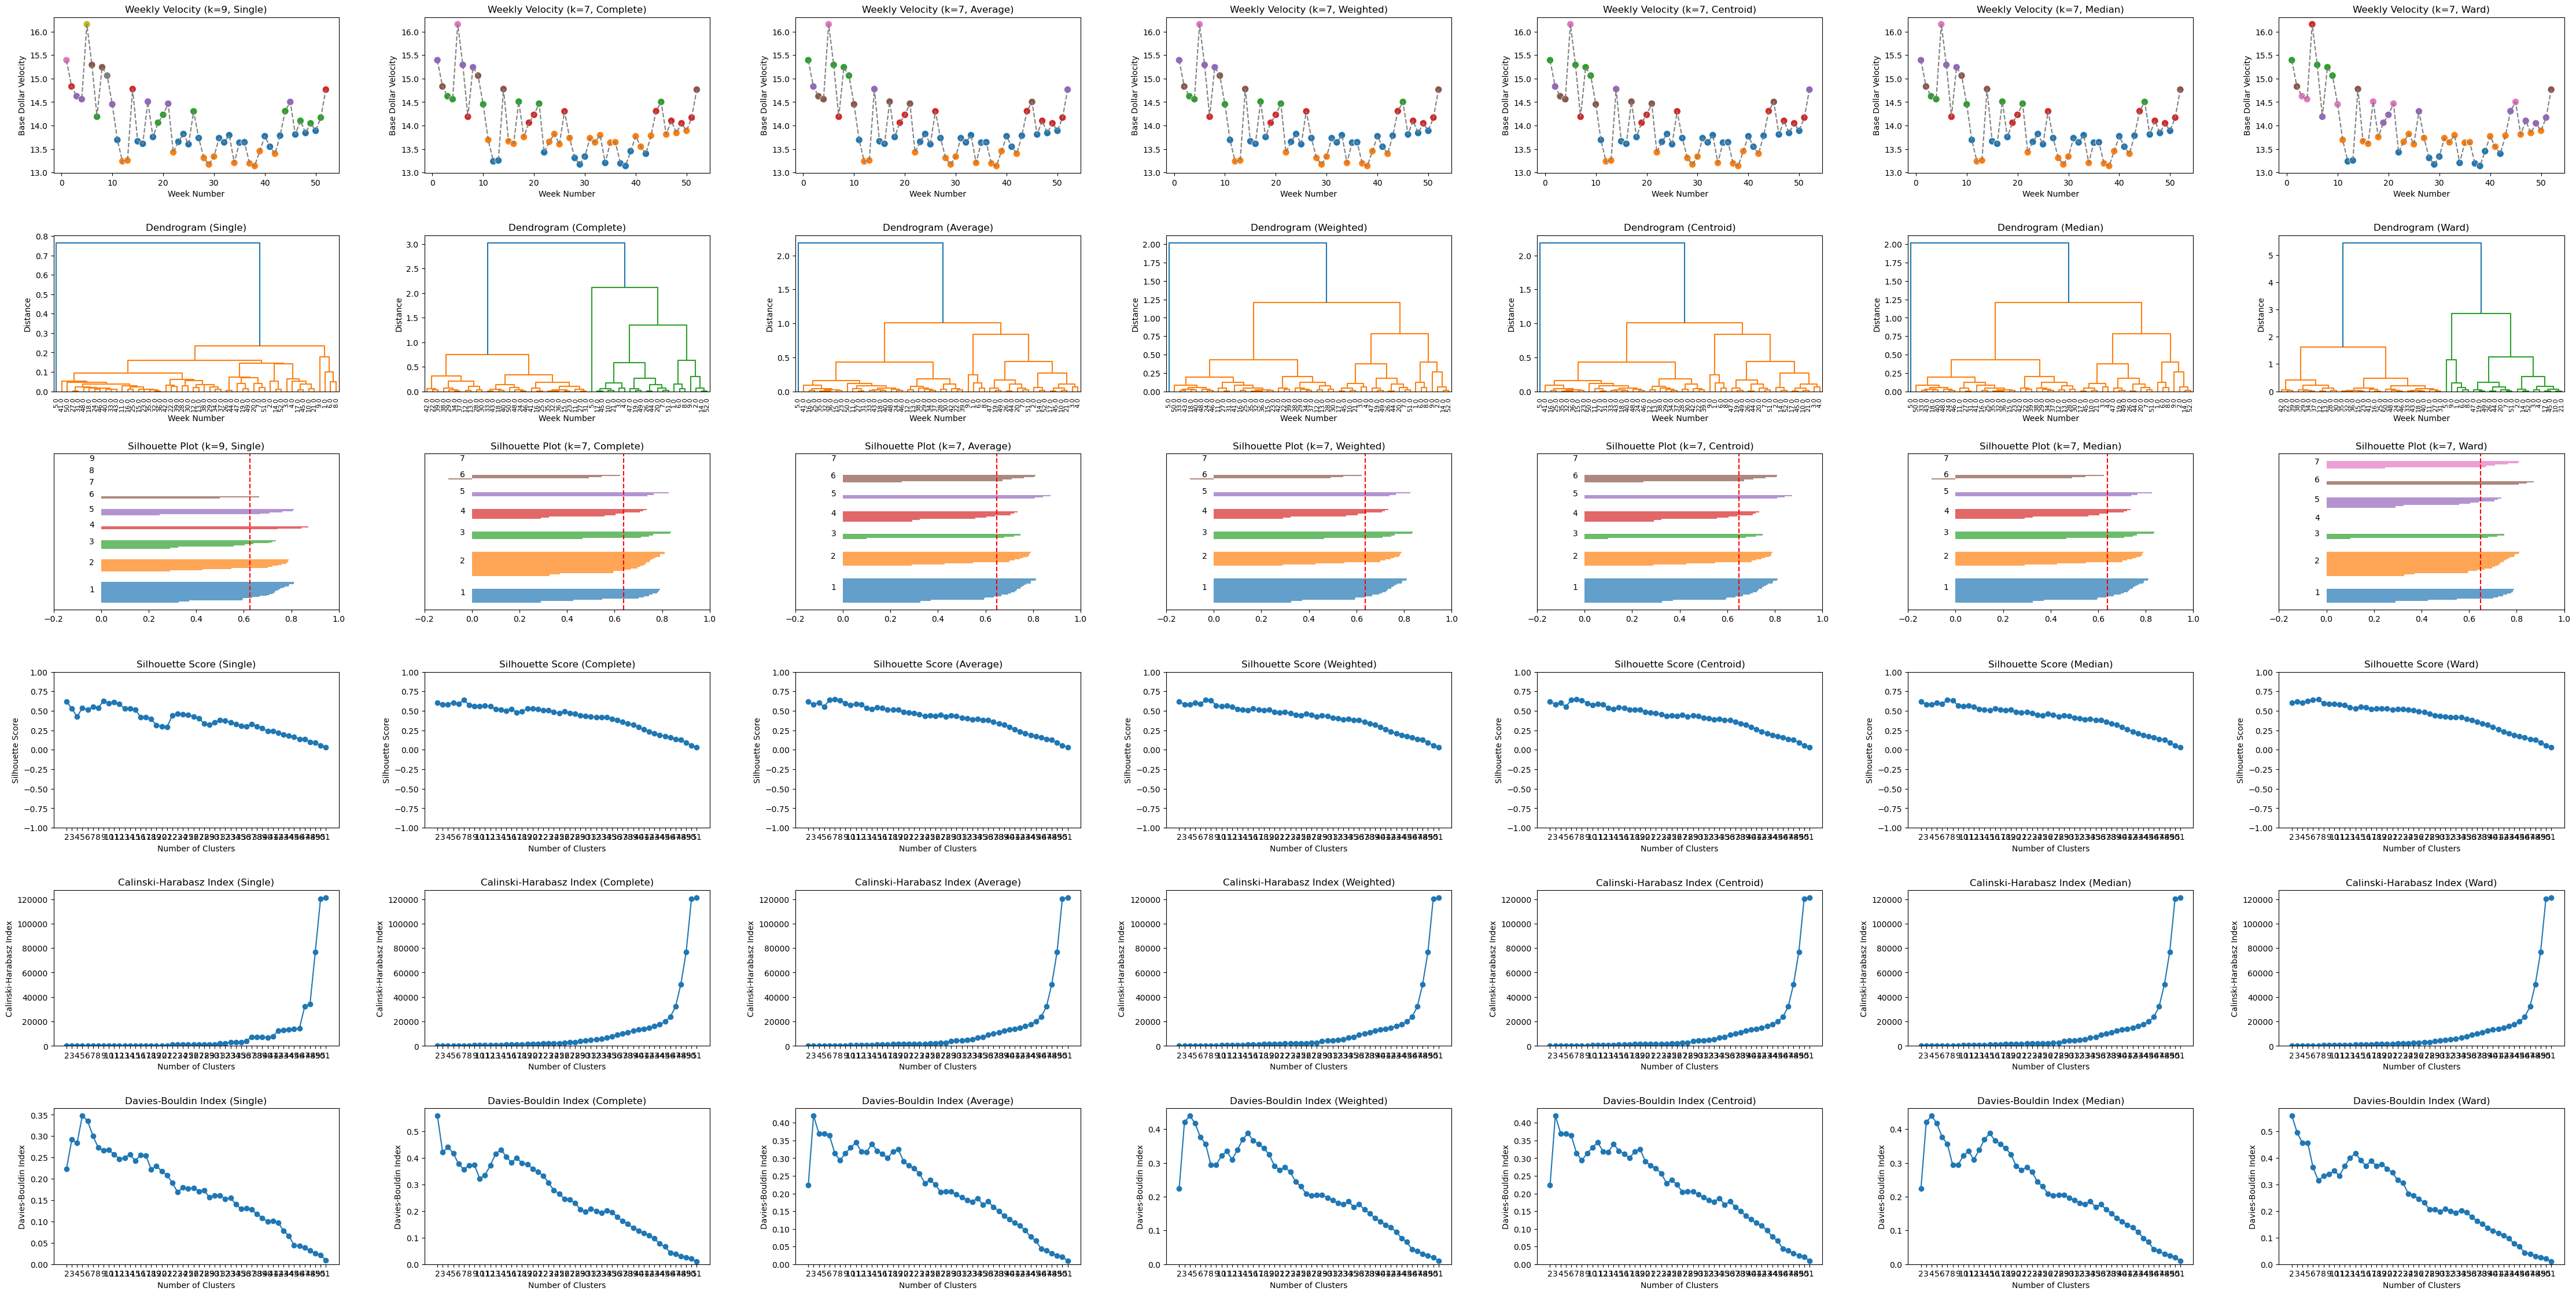

In [35]:
gavina_w_baselines_renamed = standardize_columns(gavina_w_baselines, date="OM Date", stores_selling="Number of Stores Selling", acv="Quad ACV", channel_of_trade="COT", period="Period (13)", promo_code="Auto Promo Coding", base_dollars="Base Dollar Sales",
                                                 base_units="Base Unit Sales", price_bucket="Price Buckets Half Dollar")
weekly_velocity = calculate_weekly_velocity(gavina_w_baselines_renamed, martinellis_week_lkup, account)
score_dict = compute_linkage_scores(weekly_velocity, linkage_methods, k_max=52, custom_distance=False)
plot_clustering_pipeline(weekly_velocity, score_dict)
# metrics1, metrics2, metrics3 = create_score_grids(score_dict, k_max)

In [36]:
sku = []
pg = ["DF_Cans"]
date_min = None
date_max = None
price_min = 6.49
price_max = 9.99

gavina_w_baselines_renamed = standardize_columns(gavina_w_baselines, date="OM Date", stores_selling="Number of Stores Selling", acv="Quad ACV", channel_of_trade="COT", period="Period (13)", promo_code="Auto Promo Coding", base_dollars="Auto Base Dollars",
                                                 base_units="Auto Base Units", price_bucket="Price Buckets Half Dollar")
gavina_clustered_data = map_weeks_to_clusters(gavina_w_baselines_renamed, martinellis_week_lkup, weekly_velocity, score_dict, "single")
display(gavina_clustered_data.head(4))
gavina_DI_no_season, gavina_model_no_season = run_price_factor_regression(gavina_clustered_data, sku, period_col_name="", date_min=date_min, date_max=date_max, price_min=price_min, price_max=price_max)
gavina_DI, gavina_model = run_price_factor_regression(gavina_clustered_data, sku, period_col_name="Period", date_min=date_min, date_max=date_max, price_min=price_min, price_max=price_max)
gavina_DI_clustered, gavina_model_clustered = run_price_factor_regression(gavina_clustered_data, sku, period_col_name="Period Cluster", date_min=date_min, date_max=date_max, price_min=price_min, price_max=price_max)
print("Demand Indices - No Period Factor")
display(gavina_DI_no_season)
print("Demand Indices - 13-Period Factor")
display(gavina_DI)
print("Demand Indices - Clustered Period Factor")
display(gavina_DI_clustered)
# horizontal([gavina_DI_no_season, gavina_DI, gavina_DI_clustered])
print("\n", gavina_model_no_season.summary())
print("\n", gavina_model.summary())
print("\n", gavina_model_clustered.summary())

Geography                                                SKU  \
0  Total US - Food  DON FRANCISCO'S GROUND MULTI SERVE COFFEE BAG ...   
1  Total US - Food  DON FRANCISCO'S GROUND MULTI SERVE COFFEE BAG ...   
2  Total US - Food  DON FRANCISCO'S GROUND MULTI SERVE COFFEE BAG ...   
3  Total US - Food  DON FRANCISCO'S GROUND MULTI SERVE COFFEE BAG ...   

                   Time  Dollar Sales  Unit Sales  Base Dollar Sales  \
0  Week Ending 05-28-23   3194.477435  455.727448        2745.191238   
1  Week Ending 06-04-23   3535.002553  547.601141        2206.720558   
2  Week Ending 06-11-23   2609.169793  378.204656        2330.876536   
3  Week Ending 06-18-23   2272.989877  302.578791        2208.977844   

   Base Unit Sales  ACV Weighted Distribution  \
0       365.428504                   0.708119   
1       307.664602                   0.736481   
2       323.776367                   0.668913   
3       291.857358                   0.581201   

   ACV Weighted Distribution Any Merch  Weeks in Distribution  \
0                             0.376275                      1   
1                             0.500815                      1   
2                             0.289857                      1   
3                             0.097098                      1   

   # of Stores Selling   .       OM Account    COT          ACVMM  Corp  \
0           326.412681 NaN  Total US - Food  Total  809539.491337     0   
1           275.163629 NaN  Total US - Food  Total  809539.491337     0   
2           289.943429 NaN  Total US - Food  Total  809539.491337     0   
3           275.428118 NaN  Total US - Food  Total  809539.491337     0   

   Lower       Date OM Quad Date  Period          UPC OM Product Group  \
0      0 2023-05-28   2023-06-18       6  72323048711        DFFR_Bags   
1      0 2023-06-04   2023-06-18       6  72323048711        DFFR_Bags   
2      0 2023-06-11   2023-06-18       6  72323048711        DFFR_Bags   
3      0 2023-06-18   2023-06-18       6  72323048711        DFFR_Bags   

                                             OM Name  List Price      COGS  \
0  Double French Ground Coffee Non Organic Foil B...         6.8  4.571062   
1  Double French Ground Coffee Non Organic Foil B...         6.8  4.571062   
2  Double French Ground Coffee Non Organic Foil B...         6.8  4.571062   
3  Double French Ground Coffee Non Organic Foil B...         6.8  4.571062   

   Store Weeks  ACV >5  ACV >10       L52 L12  Manual Promo Coding  \
0   326.412681       0        0  L52 YAGO   0                    0   
1   275.163629       0        0  L52 YAGO   0                    1   
2   289.943429       0        0  L52 YAGO   0                    0   
3   275.428118       0        0  L52 YAGO   0                    0   

                                         Primary Key      ACV  \
0  Total US - FoodDON FRANCISCO'S GROUND MULTI SE...  1.19055   
1  Total US - FoodDON FRANCISCO'S GROUND MULTI SE...  1.19055   
2  Total US - FoodDON FRANCISCO'S GROUND MULTI SE...  1.19055   
3  Total US - FoodDON FRANCISCO'S GROUND MULTI SE...  1.19055   

   Quad ACV Any Merch  Quad Stores Selling  Promo Code  Auto Base Price  \
0            0.685658           530.052718           1         7.548705   
1            0.685658           530.052718           1         7.548705   
2            0.685658           530.052718           1         7.548705   
3            0.685658           530.052718           0         7.512059   

   Base Units  Base Dollars  Price Buckets Dollar  Price Bucket  END  \
0  263.183490   1986.694479                  7.99          7.49  NaN   
1  263.183490   1986.694479                  7.99          7.49  NaN   
2  263.183490   1986.694479                  7.99          7.49  NaN   
3  302.578791   2272.989877                  7.99          7.49  NaN   

   Week Number  Period Cluster  
0         21.0             5.0  
1         22.0             2.0  
2         23.0             1.0  
3         24.0            

Constant price elasticity (log-log): -1.703
Constant price elasticity (log-log): -1.702
Constant price elasticity (log-log): -1.702
Demand Indices - No Period Factor


Price Percent of Base Units Demand Index
0  6.49                  3.7%         1.00
1  6.99                 12.2%         0.83
2  7.49                 15.0%         0.73
3  7.99                 41.1%         0.66
4  8.49                  8.7%         0.54
5  8.99                 16.1%         0.57
6  9.49                  1.9%         0.45
7  9.99                  1.4%         0.49

Demand Indices - 13-Period Factor


Price Percent of Base Units Demand Index
0  6.49                  3.7%         1.00
1  6.99                 12.2%         0.84
2  7.49                 15.0%         0.73
3  7.99                 41.1%         0.66
4  8.49                  8.7%         0.54
5  8.99                 16.1%         0.58
6  9.49                  1.9%         0.45
7  9.99                  1.4%         0.49

Demand Indices - Clustered Period Factor


Price Percent of Base Units Demand Index
0  6.49                  3.7%         1.00
1  6.99                 12.2%         0.89
2  7.49                 15.0%         0.77
3  7.99                 41.1%         0.69
4  8.49                  8.7%         0.57
5  8.99                 16.1%         0.61
6  9.49                  1.9%         0.46
7  9.99                  1.4%         0.49


                                OLS Regression Results                              
Dep. Variable:     np.log(Q('Base Units'))   R-squared:                       0.879
Model:                                 OLS   Adj. R-squared:                  0.878
Method:                      Least Squares   F-statistic:                     3660.
Date:                     Wed, 20 Aug 2025   Prob (F-statistic):               0.00
Time:                             21:38:51   Log-Likelihood:                -10865.
No. Observations:                    19265   AIC:                         2.181e+04
Df Residuals:                        19226   BIC:                         2.212e+04
Df Model:                               38                                         
Covariance Type:                 nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

# Appendix

### Unused Functions

In [ ]:
# Generate summary DataFrames based on score_dict
def create_score_grids(score_dict, k_max):
    methods = list(score_dict.keys())

    # 1. Grid of scores: rows=k, cols=(method, metric)
    data = []
    for k in range(1,k_max+1):
        row = {"K": k}
        for method in methods:
            for metric in ["sil", "ch", "db"]:
                vals = score_dict[method][metric]
                val = vals[k - 2] if k - 2 < len(vals) else np.nan
                row[f"{method}_{metric}"] = val
        data.append(row)
    df_scores = pd.DataFrame(data)

    # 2. Best K by metric for each method
    summary_rows = []
    for method in methods:
        row = {"Method": method}
        for metric, key in zip(["Silhouette", "CH", "DB"], ["sil", "ch", "db"]):
            scores = score_dict[method][key]
            if key == "db":
                best_k = np.nanargmin(scores) + 2 if any(~np.isnan(scores)) else np.nan
            else:
                best_k = np.nanargmax(scores) + 2 if any(~np.isnan(scores)) else np.nan
            row[f"Best K ({metric})"] = best_k
        summary_rows.append(row)
    df_best_k = pd.DataFrame(summary_rows)

    # 3. Best scores by metric across all methods
    best_scores = []
    for metric in ["sil", "ch", "db"]:
        best = {"Metric": metric.upper()}
        for method in methods:
            scores = score_dict[method][metric]
            if metric == "db":
                best[method] = np.nanmin(scores)
            else:
                best[method] = np.nanmax(scores)
        best_scores.append(best)
    df_best_scores = pd.DataFrame(best_scores)

    return df_scores.set_index("K", inplace=True), df_best_k.set_index("Method", inplace=True), df_best_scores.set_index("Metric", inplace=True)

# Previous regression function 
def run_price_factor_regression(data, sku_filter=[], pg_filter=[], period_col_name="", lower_filter=1, cot_filter="Food", acv_min=10, price_min=6.49, price_max=8.99, date_min=None, date_max=None):
    filtered_data = data[
        (data["Promo Code"] == 0) &
        (data["Lower"] == lower_filter) &
        (data["COT"] == cot_filter) &
        (data["ACV"] >= acv_min) &
        (data["Base Units"] != 0) &
        (data["Price Bucket"] >= price_min) &
        (data["Price Bucket"] <= price_max)
    ].copy()
    if len(sku_filter) != 0:
        filtered_data = filtered_data[filtered_data["SKU"].isin(sku_filter)].copy()
    if len(pg_filter) != 0:
        filtered_data = filtered_data[filtered_data["OM PG"].isin(pg_filter)].copy()
    if date_min is not None:
        filtered_data = filtered_data[filtered_data["Date"] >= date_min].copy()
    if date_max is not None:
        filtered_data = filtered_data[filtered_data["Date"] <= date_max].copy()

    filtered_data["PriceFactor"] = filtered_data["Price Bucket"].astype("category")
    filtered_data["AccountFactor"] = filtered_data["OM Account"].astype("category")
    if period_col_name:
        filtered_data["PeriodFactor"] = filtered_data[period_col_name].astype("category")
        if len(pg_filter) != 0:
            filtered_data["SKUFactor"] = filtered_data["Product"].astype("category")
            model = smf.ols(
                formula="np.log(Q('Base Units')) ~ PriceFactor + np.log(Q('ACV')) + AccountFactor + PeriodFactor + SKUFactor",
                data=filtered_data
            ).fit()
        else:
            model = smf.ols(
                formula="np.log(Q('Base Units')) ~ PriceFactor + np.log(Q('ACV')) + AccountFactor + PeriodFactor",
                data=filtered_data
            ).fit()
    else:
        if len(pg_filter) != 0:
            filtered_data["SKUFactor"] = filtered_data["Product"].astype("category")
            model = smf.ols(
                formula="np.log(Q('Base Units')) ~ PriceFactor + np.log(Q('ACV')) + AccountFactor + SKUFactor",
                data=filtered_data
            ).fit()
        else:
            model = smf.ols(
                formula="np.log(Q('Base Units')) ~ PriceFactor + np.log(Q('ACV')) + AccountFactor",
                data=filtered_data
            ).fit()

    coefs = model.params
    price_coefs = coefs[coefs.index.str.startswith("PriceFactor")]
    named_levels = price_coefs.index.str.replace("PriceFactor[T.", "", regex=False).str.replace("]", "", regex=False)
    cats = filtered_data["PriceFactor"].cat.categories
    cats_str = cats.astype(str)
    price_coefs = model.params[model.params.index.str.startswith("PriceFactor")]
    named_levels = price_coefs.index.str.replace("PriceFactor[T.", "", regex=False).str.replace("]", "", regex=False)

    # base level is the category not present in named_levels
    base_level = [c for c in cats_str if c not in list(named_levels)][0]

    all_prices = pd.Series(
        data=np.concatenate(([0], price_coefs.values)),
        index=[base_level] + list(named_levels)
    )
    demand_index = np.exp(all_prices)
    demand_index_normalized = demand_index / demand_index.max()

    demand_df = pd.DataFrame({
        "Price": demand_index_normalized.index,          # strings
        "Demand Index": demand_index_normalized.values
    })

    # --- Percent of base units per price bin (match dtypes)
    units_by_bin = filtered_data.groupby("PriceFactor", observed=True)["Base Units"].sum()
    units_by_bin = units_by_bin.reindex(cats, fill_value=0)  # ensure all bins present

    units_df = units_by_bin.rename_axis("PriceFactor").reset_index()
    units_df["Price"] = units_df["PriceFactor"].astype(str)   # make merge key a string
    total_units = units_df["Base Units"].sum()

    if total_units == 0:
        units_df["Percent of Base Units"] = 0.0
    else:
        units_df["Percent of Base Units"] = 100.0 * units_df["Base Units"] / total_units

    demand_df = demand_df.merge(
        units_df[["Price", "Percent of Base Units"]],
        on="Price",
        how="left"
    )

    if period_col_name and ("SKUFactor" in filtered_data.columns):
        elasticity_model = smf.ols(
            formula="np.log(Q('Base Units')) ~ np.log(Q('Price Bucket')) + np.log(Q('ACV')) + AccountFactor + PeriodFactor + SKUFactor",
            data=filtered_data
        ).fit()
    elif period_col_name:
        elasticity_model = smf.ols(
            formula="np.log(Q('Base Units')) ~ np.log(Q('Price Bucket')) + np.log(Q('ACV')) + AccountFactor + PeriodFactor",
            data=filtered_data
        ).fit()
    elif ("SKUFactor" in filtered_data.columns):
        elasticity_model = smf.ols(
            formula="np.log(Q('Base Units')) ~ np.log(Q('Price Bucket')) + np.log(Q('ACV')) + AccountFactor + SKUFactor",
            data=filtered_data
        ).fit()
    else:
        elasticity_model = smf.ols(
            formula="np.log(Q('Base Units')) ~ np.log(Q('Price Bucket')) + np.log(Q('ACV')) + AccountFactor",
            data=filtered_data
        ).fit()

    if "np.log(Q('Price Bucket'))" in elasticity_model.params.index:
        elasticity = elasticity_model.params["np.log(Q('Price Bucket'))"]
        print(f"Constant price elasticity (log-log): {elasticity:.3f}")
    else:
        print("Constant price elasticity could not be estimated in the log-log model.")

    demand_df["Percent of Base Units"] = demand_df["Percent of Base Units"].astype(float)

    # Format: percent with 1 decimal, demand index with 2 decimals
    demand_df["Percent of Base Units"] = demand_df["Percent of Base Units"].map(lambda x: f"{x:.1f}%")
    demand_df["Demand Index"] = demand_df["Demand Index"].map(lambda x: f"{x:.2f}")

    # Move percent to the middle: Price | Percent | Demand
    demand_df = demand_df[["Price", "Percent of Base Units", "Demand Index"]]

    if period_col_name:
        week_cluster_map = (
            filtered_data[["Week Number", period_col_name]]
            .drop_duplicates()
            .sort_values(period_col_name)
        )

        print(week_cluster_map)

    return demand_df.reset_index(drop=True), model